In [1]:
# %% [markdown]
# K = K1/(η_C · η_R · r(t)) + ( Σ_i C_i b_i / τ_C  +  Σ_j R_j b_j / τ_R  +  Σ_k S_k b_k ) / ( f · η_R · r(t) )
# τ_R/τ_C control: tau_ratio_R_over_C = τ_R / τ_C (e.g. 10 => discharge 10× faster than charge)
# b (CRF) = ι(1+ι)^y / ((1+ι)^y − 1); use ι = 0.10.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# Inputs
# ---------------------------

iota = 0.10      # interest rate (formerly u)
f = 0.1          # cycles per year
tau_ratio_R_over_C = 1.0  # τ_R / τ_C  (10.0 => discharge 10× faster than charge)
K1_EUR_per_kWh = 0.082
K1_EUR_per_MWh = 1000.0 * K1_EUR_per_kWh

# Dwell time selection:
# - scalar hours or array matching τ_R
# - None => t = 8760 / (2f)
dwell_time_hours = None

# Top-up modelling:
#  - 'no_top_up'  : energy term = K1/(η_C η_R r^t); capital denom uses r^t
#  - 'continuous' : energy term = K1*(1 + λ t)/(η_C η_R); capital denom uses r = 1
energy_topup_mode = 'no_top_up'


def crf(iota, y):
    return iota * (1 + iota) ** y / ((1 + iota) ** y - 1)

# ---------------------------
# Component data (2020 EUR) — per your table
# ---------------------------
# Conversion components (€/kW_out), with efficiency and lifetime (years)
conv_2030 = {
    "battery_pcs":            {"C":  80.0, "eta": 0.95, "y": 10},  # modelled as discharge-side only
    "electrolyser":           {"C": 804.0, "eta": 0.62, "y": 25},
    "ammonia_synthesis":      {"C":1504.0, "eta": 0.82, "y": 30},
    "ammonia_liquefaction":   {"C": 152.0, "eta": 0.99, "y": 20},  # kW_LHV_throughput
    "hydrogen_ccgt":          {"C": 883.0, "eta": 0.55, "y": 25},
    "ammonia_ccgt":           {"C": 883.0, "eta": 0.55, "y": 25},
    "h2_tank_compressor":     {"C": 586.0, "eta": 0.89, "y": 25},
    "h2_cavern_compressor":   {"C": 586.0, "eta": 0.89, "y": 25},
    "hydro_pump":             {"C": 700.0, "eta": 0.88, "y": 50},
    "hydro_turbine":          {"C": 700.0, "eta": 0.88, "y": 50},
}

conv_2050 = {
    "battery_pcs":            {"C":  70.0, "eta": 0.96, "y": 10},
    "electrolyser":           {"C": 393.0, "eta": 0.70, "y": 25},
    "ammonia_synthesis":      {"C": 943.0, "eta": 0.82, "y": 30},
    "ammonia_liquefaction":   {"C": 152.0, "eta": 0.99, "y": 20},
    "hydrogen_ccgt":          {"C": 883.0, "eta": 0.60, "y": 25},
    "ammonia_ccgt":           {"C": 883.0, "eta": 0.60, "y": 25},
    "h2_tank_compressor":     {"C": 191.0, "eta": 0.90, "y": 25},
    "h2_cavern_compressor":   {"C": 191.0, "eta": 0.90, "y": 25},
    "hydro_pump":             {"C": 700.0, "eta": 0.88, "y": 50},
    "hydro_turbine":          {"C": 700.0, "eta": 0.88, "y": 50},
}

# Storage components (€/kWh_internal), with hourly retention and lifetime
stor_2030 = {
    "battery_storage":        {"S": 200.00, "retention_per_h": 0.99995800,  "y": 20},
    "h2_tank_storage":        {"S":  25.00, "retention_per_h": 1.0,         "y": 30},
    "h2_cavern_storage":      {"S":   2.13, "retention_per_h": 1.0,         "y": 100},
    "ammonia_liquid_storage": {"S":   0.08, "retention_per_h": 1.0,         "y": 40},
    "hydro_storage":          {"S":  75.00, "retention_per_h": 1.0,         "y": 50},
}

stor_2050 = {
    "battery_storage":        {"S": 20.00, "retention_per_h": 0.99995800,  "y": 20}, # DEA battery S is 170.00
    "h2_tank_storage":        {"S":  15.00, "retention_per_h": 1.0,         "y": 30},
    "h2_cavern_storage":      {"S":   1.28, "retention_per_h": 0.99999994,  "y": 100},
    "ammonia_liquid_storage": {"S":   0.08, "retention_per_h": 0.99999909,  "y": 40},
    "hydro_storage":          {"S":  75.00, "retention_per_h": 1.0,         "y": 50},
}

# ---------------------------
# Path definitions (in/out/storage)
# ---------------------------
tech_paths = {
    "Battery": {
        "conv_in":  [],  # PCS modelled on discharge side only (avoid double counting)
        "conv_out": ["battery_pcs"],
        "storage":  ["battery_storage"],
    },
    "H2 tank": {
        "conv_in":  ["electrolyser", "h2_tank_compressor"],
        "conv_out": ["hydrogen_ccgt"],
        "storage":  ["h2_tank_storage"],
    },
    "H2 cavern": {
        "conv_in":  ["electrolyser", "h2_cavern_compressor"],
        "conv_out": ["hydrogen_ccgt"],
        "storage":  ["h2_cavern_storage"],
    },
    "Ammonia": {
        "conv_in":  ["electrolyser", "ammonia_synthesis", "ammonia_liquefaction"],
        "conv_out": ["ammonia_ccgt"],
        "storage":  ["ammonia_liquid_storage"],
    },
    "Pumped hydro": {
        "conv_in":  ["hydro_pump"],
        "conv_out": ["hydro_turbine"],
        "storage":  ["hydro_storage"],
    },
}

# ---------------------------
# Colours and styles (as before)
# ---------------------------
colours = {
    "Battery":       "#f28e2b",
    "H2 tank":       "#6bcafd",
    "H2 cavern":     "#15c4fe",
    "Ammonia":       "#59a14f",
    "Pumped hydro":  "#1f77b4",
}

linestyles = {
    "H2 cavern": "--",
    "H2 tank": "-",
    "Pumped hydro": "-",
    "Battery": "-",
    "Ammonia": "-",
}

# ---------------------------
# τ_R sweep (geometric) and τ_C via ratio τ_R/τ_C
# ---------------------------
tau_R_base = np.geomspace(0.1, 8760.0, 400)         # discharge E-to-P [h]
if tau_ratio_R_over_C <= 0:
    raise ValueError("tau_ratio_R_over_C must be > 0")
tau_C_base = tau_R_base / tau_ratio_R_over_C       # charge E-to-P [h]; τ_C = τ_R / (τ_R/τ_C)

# Guardrail vs calendar dwell (τ_R,max = 8760 / (2f))
tau_max = (8760.0 / (2.0 * f)) if f > 0 else np.inf
if np.isfinite(tau_max):
    feasible_mask = tau_R_base <= tau_max
    if not np.any(feasible_mask):
        raise ValueError("τ_R grid exceeds feasible range — reduce tau_ratio_R_over_C or extend f.")
    if not np.all(feasible_mask):
        max_tau = float(np.max(tau_R_base))
        print(f"Clipping τ_R grid at τ_R,max ≈ {tau_max:.1f} h (requested up to {max_tau:.1f} h).")
    tau_R = tau_R_base[feasible_mask]
    tau_C = tau_C_base[feasible_mask]
else:
    tau_R = tau_R_base
    tau_C = tau_C_base

# ---------------------------
# Core calculator (split equation)
# ---------------------------

def compute_K_path(tau_R, tau_C, conv, stor, path, iota=0.10, f=1.0, dwell_time_hours=None, energy_topup_mode='no_top_up'):
    # Efficiencies
    eta_C = 1.0
    eta_R = 1.0
    for comp in path["conv_in"]:
        eta_C *= conv[comp]["eta"]
    for comp in path["conv_out"]:
        eta_R *= conv[comp]["eta"]

    # CRF-weighted CAPEX sums
    sum_power_C = sum(conv[c]["C"] * crf(iota, conv[c]["y"]) for c in path["conv_in"])
    sum_power_R = sum(conv[c]["C"] * crf(iota, conv[c]["y"]) for c in path["conv_out"])

    # Storage CAPEX and retention
    sum_storage = 0.0
    retention_per_h = 1.0
    for comp in path["storage"]:
        S = stor[comp]["S"]; y = stor[comp]["y"]
        sum_storage += S * crf(iota, y)
        retention_per_h *= stor[comp]["retention_per_h"]

    # Dwell time
    if dwell_time_hours is None:
        t_eff = (8760.0 / (2.0 * f)) if f > 0 else np.inf
    else:
        t_eff = dwell_time_hours

    # Retention factors
    r_t = retention_per_h ** t_eff
    lambda_per_h = max(0.0, 1.0 - retention_per_h)

    # Energy purchase term
    if energy_topup_mode == 'no_top_up':
        K_energy = K1_EUR_per_kWh / (eta_C * eta_R * r_t)
        r_eff = r_t
    elif energy_topup_mode == 'continuous':
        topup_fraction = lambda_per_h * t_eff
        K_energy = K1_EUR_per_kWh * (1.0 + topup_fraction) / (eta_C * eta_R)
        r_eff = 1.0
    else:
        raise ValueError("Unknown energy_topup_mode")

    # Capital term (per delivered kWh)
    K_capital = ( (sum_power_C / tau_C) + (sum_power_R / tau_R) + sum_storage ) / (f * eta_R * r_eff)

    return K_energy + K_capital


def build_dataframe_for_year(conv, stor, tau_R, tau_C):
    rows = []
    for tech_name, path in tech_paths.items():
        K_vals = [compute_K_path(tr, tc, conv, stor, path, iota=iota, f=f, dwell_time_hours=dwell_time_hours,
                                 energy_topup_mode=energy_topup_mode)
                  for tr, tc in zip(tau_R, tau_C)]
        rows.append(pd.DataFrame({"tech": tech_name, "tau_R_h": tau_R, "tau_C_h": tau_C, "K_EUR_per_kWh": K_vals}))
    return pd.concat(rows, ignore_index=True)

df2030 = build_dataframe_for_year(conv_2030, stor_2030, tau_R, tau_C)
df2050 = build_dataframe_for_year(conv_2050, stor_2050, tau_R, tau_C)

# ---------------------------
# Plotting (colours & styles preserved)
# ---------------------------

def plot_K(df, title):
    fig, ax = plt.subplots(figsize=(7.5, 5.5))
    for tech in ["Battery", "H2 tank", "H2 cavern", "Ammonia", "Pumped hydro"]:
        d = df[df["tech"] == tech]
        ax.plot(d["tau_R_h"], 1000.0 * d["K_EUR_per_kWh"],
                label=tech, color=colours[tech], lw=2, linestyle=linestyles.get(tech, "-"))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(0.1, 1000)
    ax.set_xlabel(r"$(\tau_C+\tau_R)$ [h]")
    ax.set_ylabel("Total cost per delivered energy K [EUR/MWh]")
    leg = ax.legend(frameon=False, ncol=2, loc='upper right')

    # Params annotation
    t_default = (8760.0 / (2.0 * f)) if dwell_time_hours is None and f > 0 else dwell_time_hours
    t_label = (f"{t_default:.0f} h" if dwell_time_hours is None
               else (f"{dwell_time_hours:.0f} h" if np.isscalar(dwell_time_hours) else "array"))
    text = (f"f = {f}, ι = {iota:.2f}, t = {t_label}, K1 = {K1_EUR_per_MWh:.2f} EUR/MWh\n"
            f"mode = {energy_topup_mode}, τ_R/τ_C = {tau_ratio_R_over_C:g}")
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bbox = leg.get_window_extent(renderer=renderer)
    inv = ax.transAxes.inverted()
    bb = bbox.transformed(inv)
    ax.text(bb.x1, bb.y0 - 0.02, text, transform=ax.transAxes, fontsize=8, va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'),
            linespacing=1.0)

    ax.set_title(title)
    ax.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    return fig, ax

# ---------------------------
# Save helper
# ---------------------------

def save_fig(fig, output_file_tag, dpi=300, output_dir="results/images/"):
    """
    Save a Matplotlib figure with a standard filename pattern.
    Creates the output directory if it doesn't exist.
    """
    os.makedirs(output_dir, exist_ok=True)
    outpath = os.path.join(output_dir, f"lcoe_storage_math_{output_file_tag}.png")
    fig.savefig(outpath, dpi=dpi, bbox_inches="tight")
    print(f"Saved: {outpath}")
    return outpath

# ---------------------------
# Make plots
# ---------------------------
# fig2030, ax2030 = plot_K(df2030, "K versus τ_R — 2030 inputs")
# fig2050, ax2050 = plot_K(df2050, "K versus τ_R — 2050 inputs")

# Example save calls:
# save_fig(fig2030, "2030", output_dir=".")
# save_fig(fig2050, "2050", output_dir=".")


In [3]:
def _max_tau_R_for_frequency(f_value, tau_ratio):
    """Upper guardrail for τ_R based on cycling frequency; inf if unconstrained."""
    if f_value is None or f_value <= 0:
        return np.inf
    return 8760.0 / (2.0 * f_value)

In [4]:
# Ensure base dataframes expose τ-cycle explicitly
for df in (df2030, df2050):
    df["tau_cycle_h"] = df["tau_R_h"] + df["tau_C_h"]

Saved: /Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_2030_2050.png


'/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_2030_2050.png'

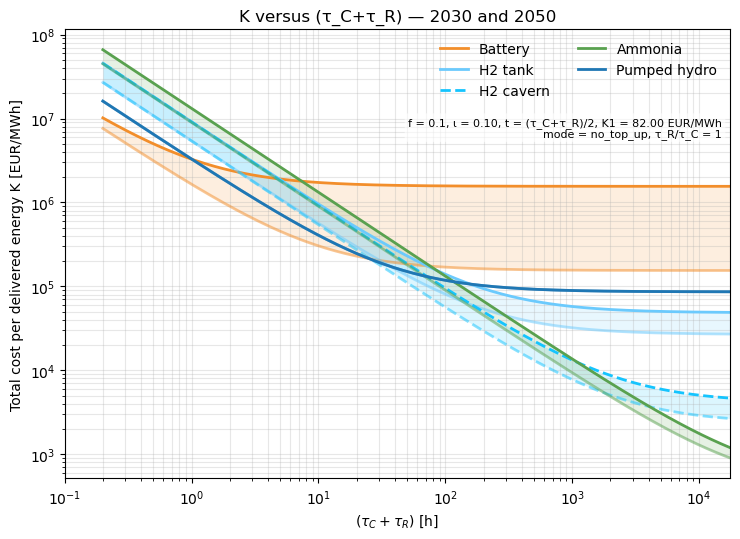

In [5]:
# 2030 vs 2050 overlay and shared helpers
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


def build_dataframe_for_year_with_f(conv, stor, tau_R_grid, f_value):
    """Recompute K over a τ_R grid for a specific cycling frequency f."""
    tau_R_grid = np.asarray(tau_R_grid, dtype=float)
    if tau_R_grid.size == 0:
        return pd.DataFrame({
            "tech": [],
            "tau_R_h": [],
            "tau_C_h": [],
            "tau_cycle_h": [],
            "K_EUR_per_kWh": [],
        })
    tau_C_grid = tau_R_grid / tau_ratio_R_over_C
    tau_cycle_grid = tau_R_grid + tau_C_grid
    rows = []
    for tech_name, path in tech_paths.items():
        K_vals = [
            compute_K_path(
                float(tr),
                float(tc),
                conv,
                stor,
                path,
                iota=iota,
                f=f_value,
                dwell_time_hours=dwell_time_hours,
                energy_topup_mode=energy_topup_mode,
            )
            for tr, tc in zip(tau_R_grid, tau_C_grid)
        ]
        rows.append(pd.DataFrame({
            "tech": tech_name,
            "tau_R_h": tau_R_grid,
            "tau_C_h": tau_C_grid,
            "tau_cycle_h": tau_cycle_grid,
            "K_EUR_per_kWh": K_vals,
        }))
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()


def plot_both_years_on_ax(ax, df2030_local, df2050_local):
    techs = ["Battery", "H2 tank", "H2 cavern", "Ammonia", "Pumped hydro"]
    for tech in techs:
        d30 = (df2030_local[df2030_local["tech"] == tech]
               [["tau_cycle_h", "K_EUR_per_kWh"]]
               .rename(columns={"K_EUR_per_kWh": "K_2030"}))
        d50 = (df2050_local[df2050_local["tech"] == tech]
               [["tau_cycle_h", "K_EUR_per_kWh"]]
               .rename(columns={"K_EUR_per_kWh": "K_2050"}))
        if d30.empty or d50.empty:
            continue
        m = pd.merge(d30, d50, on="tau_cycle_h", how="inner").sort_values("tau_cycle_h")
        if m.empty:
            continue
        x = m["tau_cycle_h"].values
        y30 = 1000.0 * m["K_2030"].values
        y50 = 1000.0 * m["K_2050"].values

        ax.plot(x, y30, label=tech, color=colours[tech],
                lw=2, linestyle=linestyles.get(tech, "-"))
        ax.plot(x, y50, color=colours[tech],
                lw=2, linestyle=linestyles.get(tech, "-"), alpha=0.5)
        ax.fill_between(x, y30, y50, color=colours[tech], alpha=0.15, linewidth=0)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$(\tau_C+\tau_R)$ [h]")
    ax.set_ylabel("Total cost per delivered energy K [EUR/MWh]")
    leg = ax.legend(frameon=False, ncol=2, loc='upper right')
    return leg


def plot_K_both_years(df2030, df2050, title):
    fig, ax = plt.subplots(figsize=(7.5, 5.5))
    leg = plot_both_years_on_ax(ax, df2030, df2050)

    tau_max_local = _max_tau_R_for_frequency(f, tau_ratio_R_over_C)
    cycle_max_local = tau_max_local * (1.0 + 1.0 / tau_ratio_R_over_C) if np.isfinite(tau_max_local) else np.inf
    if np.isfinite(cycle_max_local):
        x_upper = min(1e4, cycle_max_local)
    else:
        x_upper = 1e4
    if not df2030.empty and not df2050.empty:
        data_xmax = float(max(df2030["tau_cycle_h"].max(), df2050["tau_cycle_h"].max()))
    else:
        data_xmax = 0.2
    x_upper = max(data_xmax, x_upper)
    ax.set_xlim(0.1, x_upper)

    if dwell_time_hours is None:
        t_label = "(τ_C+τ_R)/2"
    else:
        t_label = (f"{dwell_time_hours:.0f} h" if np.isscalar(dwell_time_hours) else "array")
    text = (f"f = {f}, ι = {iota:.2f}, t = {t_label}, "
            f"K1 = {K1_EUR_per_MWh:.2f} EUR/MWh\n"
            f"mode = {energy_topup_mode}, τ_R/τ_C = {tau_ratio_R_over_C:g}")
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bbox = leg.get_window_extent(renderer=renderer)
    inv = ax.transAxes.inverted()
    bb = bbox.transformed(inv)
    ax.text(bb.x1, bb.y0 - 0.02, text, transform=ax.transAxes, fontsize=8,
            va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'),
            linespacing=1.0)

    ax.set_title(title)
    ax.grid(True, which="both", alpha=0.3)
    plt.tight_layout()
    return fig, ax


fig_both, ax_both = plot_K_both_years(df2030, df2050, "K versus (τ_C+τ_R) — 2030 and 2050")
save_fig(fig_both, "2030_2050", output_dir="/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images")

Saved: /Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_2030_2050_multi_f.png


'/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_2030_2050_multi_f.png'

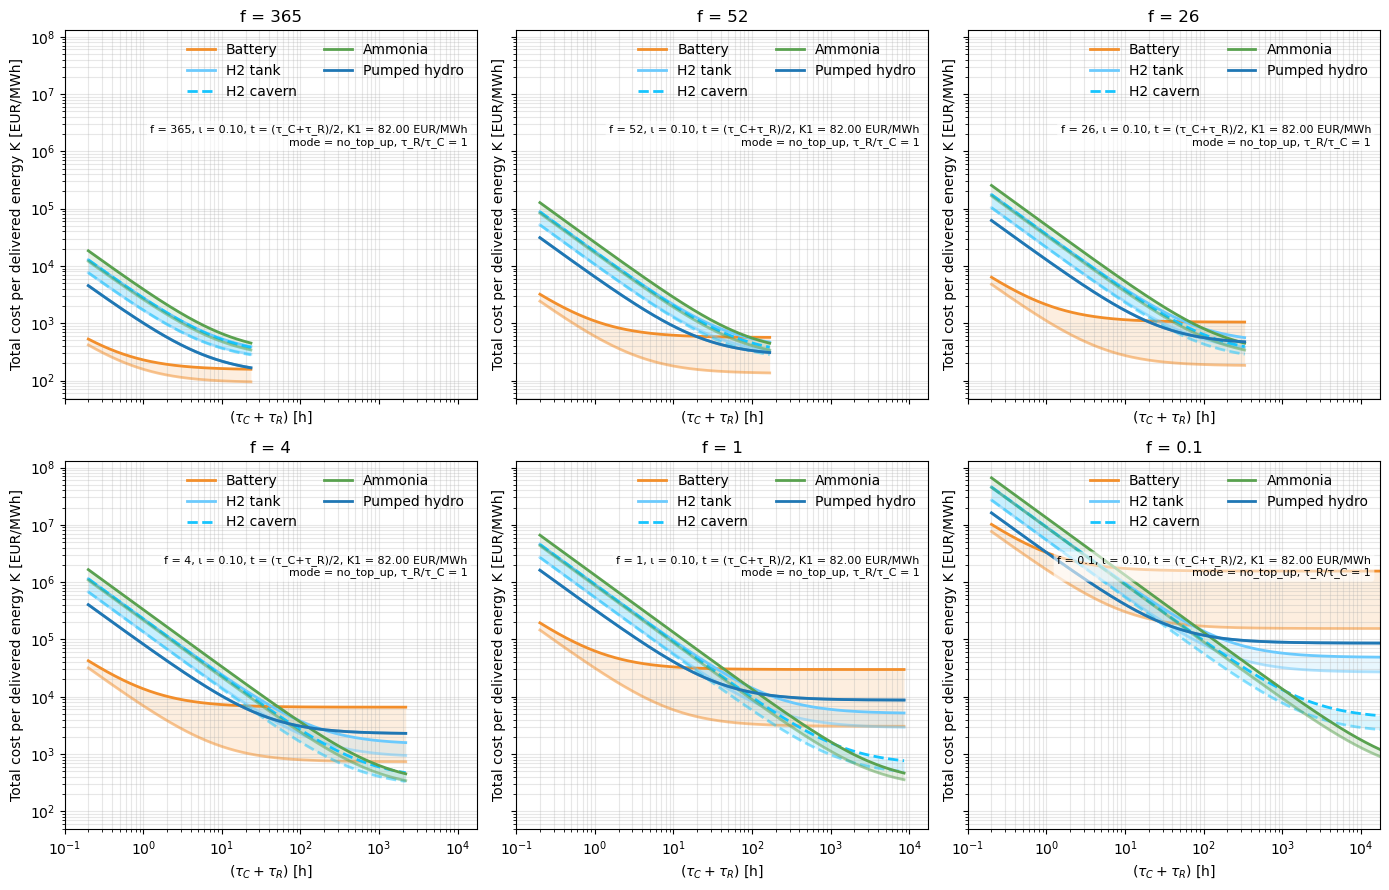

In [6]:
# Multiplot: six combined 2030/2050 plots varying f
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Ensure the base τ_R grid exists
try:
    _ = tau_R
except NameError:
    tau_R = np.geomspace(0.1, 8760.0, 400)

f_values = [365, 52, 26, 4, 1, 0.1]
fig, axes = plt.subplots(2, 3, figsize=(14, 9), sharex=True, sharey=True)
axes = axes.flatten()

for i, f_val in enumerate(f_values):
    ax = axes[i]
    # Build a τ_R grid clipped to (τ_C+τ_R) feasibility for this f
    tau_max_local = _max_tau_R_for_frequency(f_val, tau_ratio_R_over_C)
    if np.isfinite(tau_max_local):
        tau_R_local = tau_R[tau_R <= tau_max_local + 1e-9]
    else:
        tau_R_local = tau_R
    if tau_R_local.size == 0:
        tau_R_local = np.array([0.1])

    # Recompute per f to honour the charge/discharge workflow
    df2030_f = build_dataframe_for_year_with_f(conv_2030, stor_2030, tau_R_local, f_val)
    df2050_f = build_dataframe_for_year_with_f(conv_2050, stor_2050, tau_R_local, f_val)

    # Plot and get legend to anchor annotation
    leg = plot_both_years_on_ax(ax, df2030_f, df2050_f)

    # Per-panel parameter annotation below legend, aligned to its right edge
    if dwell_time_hours is None:
        t_label = "(τ_C+τ_R)/2"
    else:
        t_label = (f"{dwell_time_hours:.0f} h" if np.isscalar(dwell_time_hours) else "array")
    text = (f"f = {f_val}, ι = {iota:.2f}, t = {t_label}, "
            f"K1 = {K1_EUR_per_MWh:.2f} EUR/MWh\n"
            f"mode = {energy_topup_mode}, τ_R/τ_C = {tau_ratio_R_over_C:g}")
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bbox = leg.get_window_extent(renderer=renderer)
    inv = ax.transAxes.inverted()
    bb = bbox.transformed(inv)
    x_pos = bb.x1
    y_pos = bb.y0 - 0.02
    ax.text(x_pos, y_pos, text, transform=ax.transAxes, fontsize=8, va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'))

    # Dynamic x-limit per panel based on feasibility and desired cap of 1e4
    if np.isfinite(tau_max_local):
        cycle_cap = tau_max_local * (1.0 + 1.0 / tau_ratio_R_over_C)
        x_upper = min(1e4, cycle_cap)
    else:
        x_upper = 1e4
    cycle_candidates = []
    if not df2030_f.empty:
        cycle_candidates.append(float(df2030_f["tau_cycle_h"].max()))
    if not df2050_f.empty:
        cycle_candidates.append(float(df2050_f["tau_cycle_h"].max()))
    data_xmax = max(cycle_candidates) if cycle_candidates else 0.2
    x_upper = max(data_xmax, x_upper)
    ax.set_xlim(0.1, x_upper)

    ax.set_title(f"f = {f_val}")
    ax.grid(True, which="both", alpha=0.3)

plt.tight_layout()
save_fig(fig, "2030_2050_multi_f", output_dir="/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images")

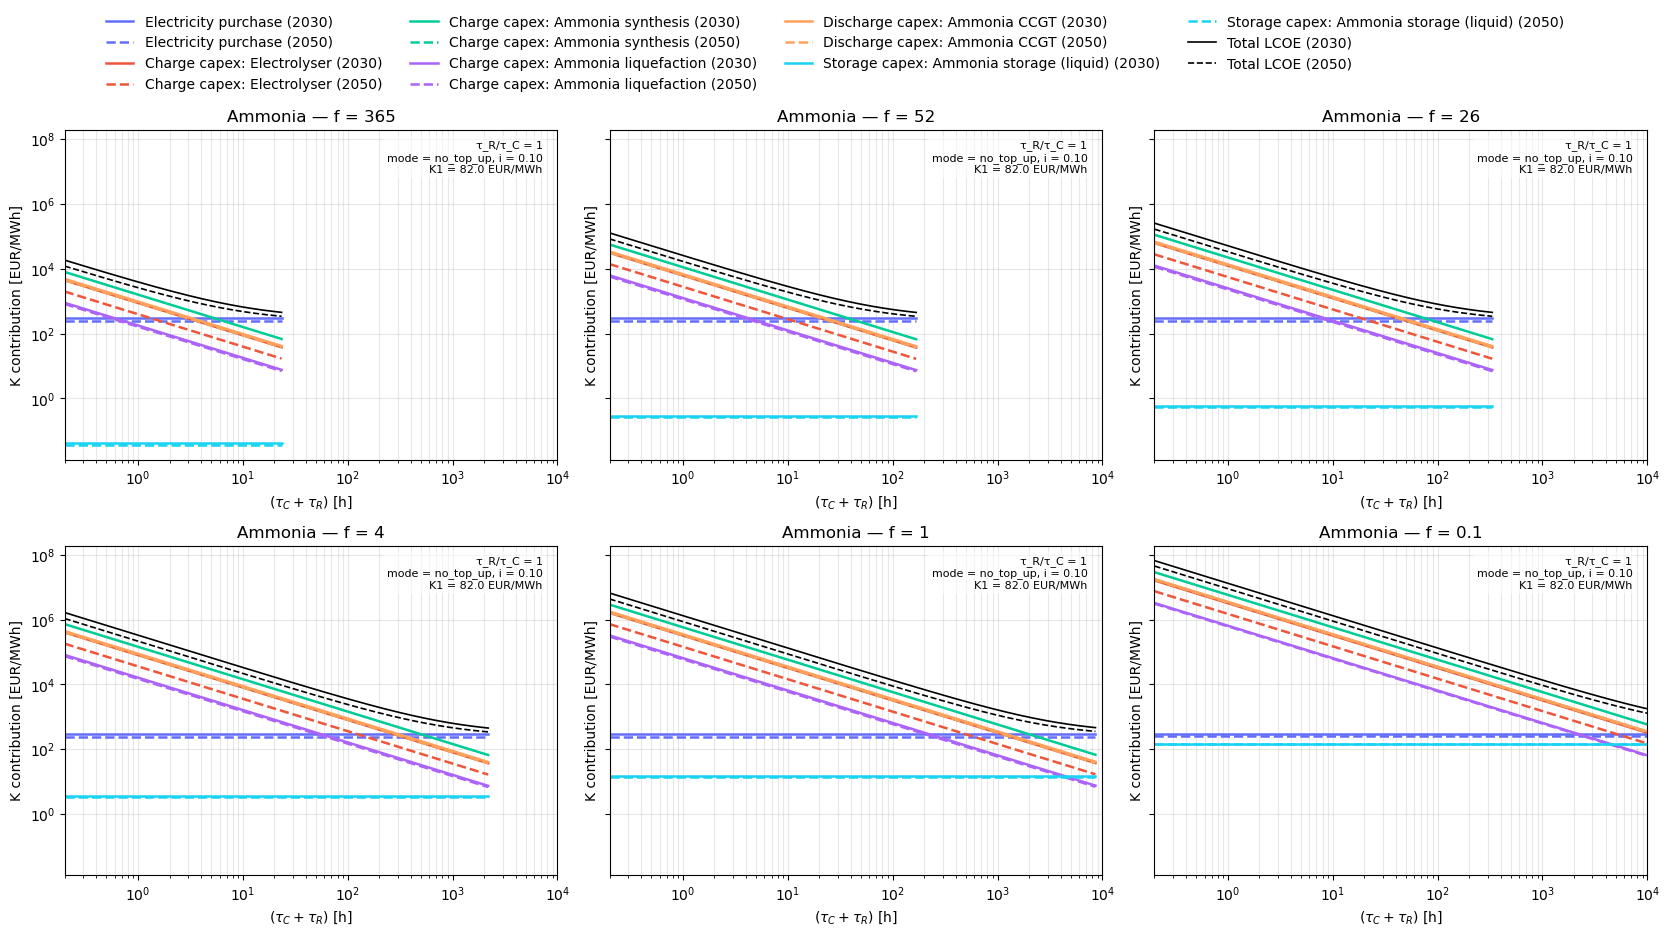

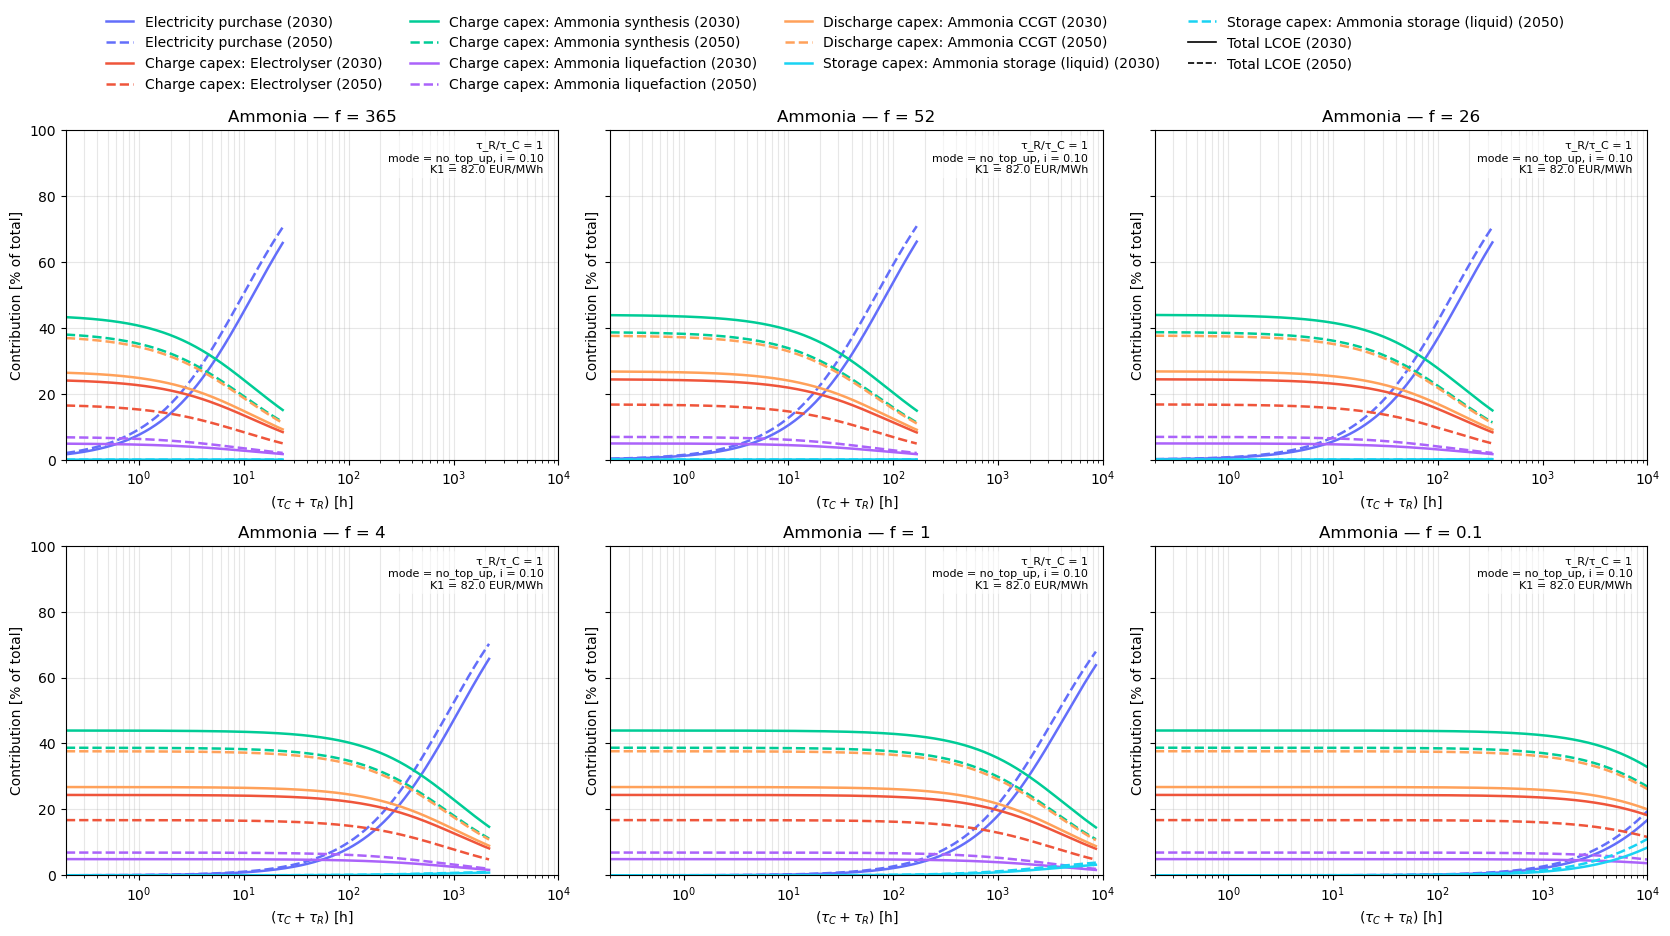

In [7]:
from collections import OrderedDict
import re

from IPython.display import display
from plotly.colors import qualitative as plotly_qualitative

component_label_map = {
    "battery_pcs": "Battery PCS",
    "electrolyser": "Electrolyser",
    "ammonia_synthesis": "Ammonia synthesis",
    "ammonia_liquefaction": "Ammonia liquefaction",
    "hydrogen_ccgt": "Hydrogen CCGT",
    "ammonia_ccgt": "Ammonia CCGT",
    "h2_tank_compressor": "Hydrogen compressor (tank)",
    "h2_cavern_compressor": "Hydrogen compressor (cavern)",
    "hydro_pump": "Hydro pump",
    "hydro_turbine": "Hydro turbine",
    "battery_storage": "Battery storage",
    "h2_tank_storage": "Hydrogen storage (tank)",
    "h2_cavern_storage": "Hydrogen storage (cavern)",
    "ammonia_liquid_storage": "Ammonia storage (liquid)",
    "hydro_storage": "Hydro storage",
}


def _nice_component_name(key: str) -> str:
    return component_label_map.get(key, key.replace("_", " ").title())


def compute_component_breakdown(
    path_key: str,
    tau_R_hours: float,
    f_value: float,
    conv_dict: dict,
    stor_dict: dict,
    energy_mode: str | None = None,
    tol: float = 1e-3,
):
    if energy_mode is None:
        energy_mode = energy_topup_mode
    if f_value <= 0:
        raise ValueError("f_value must be positive.")
    tau_C_hours = tau_R_hours / tau_ratio_R_over_C
    if tau_C_hours <= 0:
        raise ValueError("τ_C must be positive.")
    tau_limit = _max_tau_R_for_frequency(f_value, tau_ratio_R_over_C)
    if tau_R_hours > tau_limit + 1e-9:
        raise ValueError(
            f"τ_R = {tau_R_hours:.2f} h exceeds the feasible limit of {tau_limit:.2f} h for f = {f_value}."
        )
    path = tech_paths[path_key]
    eta_C = 1.0
    eta_R = 1.0
    for comp in path["conv_in"]:
        eta_C *= conv_dict[comp]["eta"]
    for comp in path["conv_out"]:
        eta_R *= conv_dict[comp]["eta"]

    dwell_override = dwell_time_hours if dwell_time_hours is not None else None
    if dwell_override is None:
        t_eff = (8760.0 / (2.0 * f_value)) if f_value > 0 else np.inf
    else:
        t_eff = float(np.asarray(dwell_override).reshape(-1)[0])

    retention_per_h = 1.0
    for comp in path["storage"]:
        retention_per_h *= stor_dict[comp]["retention_per_h"]
    r_t = retention_per_h ** t_eff
    lambda_per_h = max(0.0, 1.0 - retention_per_h)

    if energy_mode == "no_top_up":
        K_energy = K1_EUR_per_kWh / (eta_C * eta_R * r_t)
        r_eff = r_t
    elif energy_mode == "continuous":
        K_energy = K1_EUR_per_kWh * (1.0 + lambda_per_h * t_eff) / (eta_C * eta_R)
        r_eff = 1.0
    else:
        raise ValueError("Unknown energy_mode.")

    denom = f_value * eta_R * r_eff
    contributions = OrderedDict()
    contributions["Electricity purchase"] = K_energy

    for comp in path["conv_in"]:
        label = f"Charge capex: {_nice_component_name(comp)}"
        annuity = conv_dict[comp]["C"] * crf(iota, conv_dict[comp]["y"])
        contributions[label] = (annuity / tau_C_hours) / denom

    for comp in path["conv_out"]:
        label = f"Discharge capex: {_nice_component_name(comp)}"
        annuity = conv_dict[comp]["C"] * crf(iota, conv_dict[comp]["y"])
        contributions[label] = (annuity / tau_R_hours) / denom

    for comp in path["storage"]:
        label = f"Storage capex: {_nice_component_name(comp)}"
        annuity = stor_dict[comp]["S"] * crf(iota, stor_dict[comp]["y"])
        contributions[label] = annuity / denom

    total_expected = compute_K_path(
        tau_R_hours,
        tau_C_hours,
        conv_dict,
        stor_dict,
        path,
        iota=iota,
        f=f_value,
        dwell_time_hours=dwell_override,
        energy_topup_mode=energy_mode,
    )
    total_actual = sum(contributions.values())
    diff = total_expected - total_actual
    dyn_tol = max(tol, 1e-4 * abs(total_expected))
    if abs(diff) > dyn_tol:
        raise RuntimeError(
            f"Component contributions ({total_actual:.6f}) do not sum to total K ({total_expected:.6f})."
        )
    if abs(diff) > 0:
        contributions["Electricity purchase"] += diff
    return contributions


def build_component_contribution_curves(
    path_key: str,
    tau_R_grid: np.ndarray,
    f_value: float,
    conv_dict: dict,
    stor_dict: dict,
    year_label: str,
    energy_mode: str | None = None,
) -> pd.DataFrame:
    records = []
    tau_cycle_factor = 1.0 + 1.0 / tau_ratio_R_over_C
    for tau_val in np.asarray(tau_R_grid, dtype=float):
        contributions = compute_component_breakdown(
            path_key, float(tau_val), f_value, conv_dict, stor_dict, energy_mode
        )
        tau_cycle_h = float(tau_val * tau_cycle_factor)
        for comp_label, value in contributions.items():
            records.append(
                {
                    "tau_R_h": float(tau_val),
                    "tau_cycle_h": tau_cycle_h,
                    "component": comp_label,
                    "K_EUR_per_MWh": value * 1000.0,
                    "year": year_label,
                    "is_total": False,
                }
            )
        total_K = sum(contributions.values())
        records.append(
            {
                "tau_R_h": float(tau_val),
                "tau_cycle_h": tau_cycle_h,
                "component": "Total LCOE",
                "K_EUR_per_MWh": total_K * 1000.0,
                "year": year_label,
                "is_total": True,
            }
        )
    return pd.DataFrame.from_records(records)


def plot_component_contributions_vs_tau(
    path_key: str,
    f_values,
    energy_mode: str | None = None,
    tau_grid_base: np.ndarray | None = None,
    as_percent: bool = False,
):
    if tau_grid_base is None:
        tau_grid_base = tau_R_base if "tau_R_base" in globals() else np.geomspace(0.1, 8760.0, 400)
    tau_grid_base = np.asarray(tau_grid_base, dtype=float)
    if np.isscalar(f_values):
        f_values = [float(f_values)]
    f_values = list(f_values)
    if not f_values:
        raise ValueError("f_values cannot be empty.")

    years = [("2030", conv_2030, stor_2030), ("2050", conv_2050, stor_2050)]
    linestyle_map = {"2030": "-", "2050": "--"}
    total_colour = "#000000"
    palette_colors = [c for c in plotly_qualitative.Plotly if c.lower() != total_colour.lower()]
    if not palette_colors:
        palette_colors = plotly_qualitative.Plotly
    component_color_map: dict[str, str] = {}

    def get_color(component: str, is_total: bool) -> str:
        if is_total:
            return total_colour
        if component not in component_color_map:
            component_color_map[component] = palette_colors[len(component_color_map) % len(palette_colors)]
        return component_color_map[component]

    n_panels = len(f_values)
    n_cols = min(3, n_panels)
    n_rows = int(np.ceil(n_panels / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.6 * n_cols, 4.6 * n_rows), sharey=True)
    axes = np.atleast_2d(axes)
    for ax in axes.flat[n_panels:]:
        ax.set_visible(False)

    tau_cycle_factor = 1.0 + 1.0 / tau_ratio_R_over_C
    global_x_lower = max(0.1, float(np.min(tau_grid_base) * tau_cycle_factor))
    global_x_upper = min(1e4, float(np.max(tau_grid_base) * tau_cycle_factor))
    global_labels: set[str] = set()

    for ax, f_val in zip(axes.flat, f_values):
        tau_limit = _max_tau_R_for_frequency(f_val, tau_ratio_R_over_C)
        tau_grid = tau_grid_base[tau_grid_base <= tau_limit + 1e-9]
        if tau_grid.size == 0:
            ax.set_visible(False)
            continue
        year_dfs = {}
        component_order: list[str] = []
        for year_label, conv_dict, stor_dict in years:
            df_year = build_component_contribution_curves(
                path_key, tau_grid, f_val, conv_dict, stor_dict, year_label, energy_mode
            )
            if df_year.empty:
                continue
            totals = (
                df_year[df_year["is_total"]][["tau_cycle_h", "K_EUR_per_MWh"]]
                .rename(columns={"K_EUR_per_MWh": "total_value"})
            )
            df_year = df_year.merge(totals, on="tau_cycle_h", how="left")
            if as_percent:
                with np.errstate(divide="ignore", invalid="ignore"):
                    df_year["plot_value"] = np.where(
                        df_year["is_total"],
                        100.0,
                        np.where(
                            df_year["total_value"] > 0,
                            100.0 * df_year["K_EUR_per_MWh"] / df_year["total_value"],
                            0.0,
                        ),
                    )
            else:
                df_year["plot_value"] = df_year["K_EUR_per_MWh"]
            year_dfs[year_label] = df_year
            for comp_label in df_year["component"].unique():
                if comp_label not in component_order:
                    component_order.append(comp_label)

        for comp_label in component_order:
            is_total = comp_label == "Total LCOE"
            color = get_color(comp_label, is_total)
            for year_label in ("2030", "2050"):
                df_plot = year_dfs.get(year_label)
                if df_plot is None:
                    continue
                subset = df_plot[df_plot["component"] == comp_label]
                if subset.empty:
                    continue
                linestyle = linestyle_map[year_label]
                label = f"{comp_label} ({year_label})" if not is_total else f"Total LCOE ({year_label})"
                display_label = label if label not in global_labels else "_nolegend_"
                ax.plot(
                    subset["tau_cycle_h"],
                    subset["plot_value"],
                    color=color,
                    linestyle=linestyle,
                    linewidth=1.2 if is_total else 1.8,
                    label=display_label,
                )
                global_labels.add(label)

        ax.set_xscale("log")
        if as_percent:
            ax.set_yscale("linear")
            ax.set_ylim(0, 100)
            ax.set_ylabel("Contribution [% of total]")
        else:
            ax.set_yscale("log")
            ax.set_ylabel("K contribution [EUR/MWh]")
        ax.grid(True, which="both", alpha=0.3)
        ax.set_xlabel(r"$(\tau_C+\tau_R)$ [h]")
        ax.set_xlim(global_x_lower, global_x_upper)
        ax.set_title(f"{path_key} — f = {f_val}")

        annotation_text = (
            f"τ_R/τ_C = {tau_ratio_R_over_C:g}\n"
            f"mode = {energy_mode or energy_topup_mode}, i = {iota:.2f}\n"
            f"K1 = {K1_EUR_per_MWh:.1f} EUR/MWh"
        )
        ax.text(
            0.97,
            0.97,
            annotation_text,
            transform=ax.transAxes,
            fontsize=8,
            va='top',
            ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.55, edgecolor='none'),
        )

    handles, labels = axes.flat[0].get_legend_handles_labels()
    if handles:
        fig.legend(
            handles,
            labels,
            loc="upper center",
            frameon=False,
            ncol=min(len(labels), 4),
            bbox_to_anchor=(0.5, 1.02),
        )
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    return fig


component_f_values = [365, 52, 26, 4, 1, 0.1]
component_path_to_plot = "Ammonia"  # Options: Battery, Ammonia, H2 tank, H2 cavern
component_plots_save_to_disk = False
COMPONENT_PLOT_OUTPUT_DIR = "/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images"


def _slugify_path_name(value: str) -> str:
    slug = re.sub(r"[^A-Za-z0-9]+", "_", value).strip("_").lower()
    return slug or "path"


fig_component_abs = plot_component_contributions_vs_tau(
    component_path_to_plot, component_f_values
)
if component_plots_save_to_disk:
    slug = _slugify_path_name(component_path_to_plot)
    save_fig(
        fig_component_abs,
        f"component_contributions_{slug}_multi_f",
        output_dir=COMPONENT_PLOT_OUTPUT_DIR,
    )
display(fig_component_abs)
plt.close(fig_component_abs)

fig_component_pct = plot_component_contributions_vs_tau(
    component_path_to_plot, component_f_values, as_percent=True
)
if component_plots_save_to_disk:
    slug = _slugify_path_name(component_path_to_plot)
    save_fig(
        fig_component_pct,
        f"component_contributions_{slug}_multi_f_percent",
        output_dir=COMPONENT_PLOT_OUTPUT_DIR,
    )
display(fig_component_pct)
plt.close(fig_component_pct)


Saved: /Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_transmission_2030_2050_cf1_continuous.png
Saved: /Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_transmission_2030_2050_multi_cf.png
Saved: /Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_transmission_2030_2050_multi_cf.png


'/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_transmission_2030_2050_multi_cf.png'

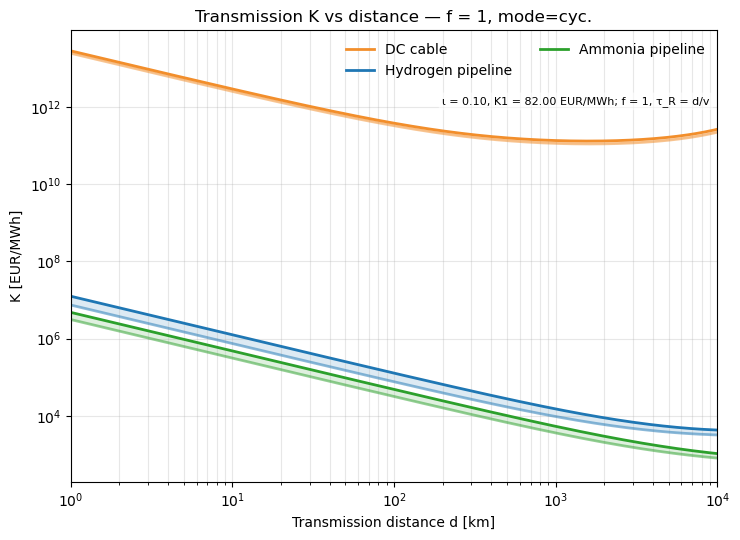

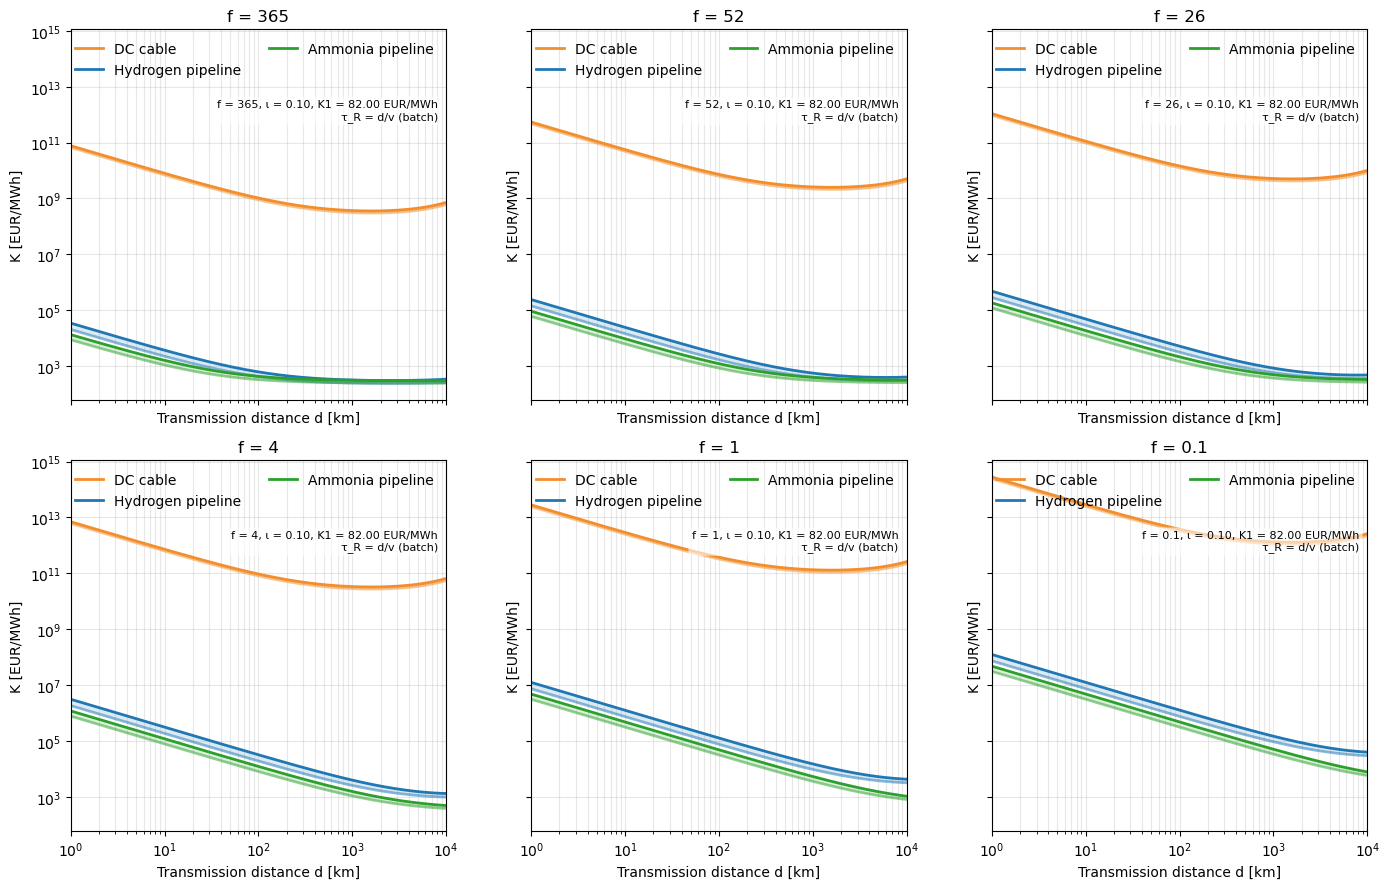

In [8]:
# Transmission techno-economic inputs
trans_lines_2030 = {
    "DC cable": {
        "T": 0.60,
        "retention_per_km": 0.9998995,
        "y_T": 50,
        "opex_frac": 0.015,
        "v_mps": 2.84802835e8,
        "kappa": 0.7,
    },
    "Hydrogen pipeline": {
        "T": 0.40,
        "retention_per_km": 0.9999808,
        "y_T": 50,
        "opex_frac": 0.001,
        "v_mps": 7.6,
        "kappa": 1.0,
    },
    "Ammonia pipeline": {
        "T": 0.20,
        "retention_per_km": 0.9999989995,
        "y_T": 50,
        "opex_frac": 0.000,
        "v_mps": 2.0,
        "kappa": 1.0,
    },
}

trans_lines_2050 = {
    "DC cable": {
        "T": 0.50,
        "retention_per_km": 0.9998995,
        "y_T": 40,
        "opex_frac": 0.015,
        "v_mps": 2.84802835e8,
        "kappa": 0.7,
    },
    "Hydrogen pipeline": {
        "T": 0.40,
        "retention_per_km": 0.9999870,
        "y_T": 50,
        "opex_frac": 0.001,
        "v_mps": 7.6,
        "kappa": 1.0,
    },
    "Ammonia pipeline": {
        "T": 0.20,
        "retention_per_km": 0.9999989995,
        "y_T": 50,
        "opex_frac": 0.000,
        "v_mps": 2.0,
        "kappa": 1.0,
    },
}

# Path definitions by tech (terminals from conv_20xx)
trans_paths = {
    "DC cable": {
        "conv_in":  ["battery_pcs"],
        "conv_out": ["battery_pcs"],
        "line_key": "DC cable",
    },
    "Hydrogen pipeline": {
        "conv_in":  ["electrolyser", "h2_tank_compressor"],
        "conv_out": ["hydrogen_ccgt"],
        "line_key": "Hydrogen pipeline",
    },
    "Ammonia pipeline": {
        "conv_in":  ["electrolyser", "ammonia_synthesis", "ammonia_liquefaction"],
        "conv_out": ["ammonia_ccgt"],
        "line_key": "Ammonia pipeline",
    },
}

# Colours and styles
colours_trans = {"DC cable": "#f28e2b", "Hydrogen pipeline": "#1f77b4", "Ammonia pipeline": "#2ca02c"}
linestyles_trans = {"DC cable": "-", "Hydrogen pipeline": "-", "Ammonia pipeline": "-"}

HOURS_PER_YEAR = 8760.0
SECONDS_PER_HOUR = 3600.0

# φ / f configuration for transmission plots
trans_phi_mode = 'cyclic'  # options: 'continuous', 'cyclic'
trans_continuous_params = {
    "primary_u": 1.0,
    "multi_u_values": [1.0, 0.7, 0.5, 0.1, 0.01, 0.001],
}
trans_cyclic_params = {
    "primary_f": 1.0,
    "multi_f_values": [365, 52, 26, 4, 1, 0.1],  # cycles/year
}


def _transit_time_hours(line_dict: dict, distance_km: float | np.ndarray) -> np.ndarray:
    v_mps = max(1e-9, float(line_dict["v_mps"]))
    distance_km = np.asarray(distance_km, dtype=float)
    return (distance_km * 1000.0) / (v_mps * SECONDS_PER_HOUR)


def transmission_continuous_phi_hours(u_value: float) -> float:
    u_val = max(1e-6, float(u_value))
    return u_val * HOURS_PER_YEAR


def transmission_mode_strings(mode: str, param: float):
    if mode == 'continuous':
        phi = transmission_continuous_phi_hours(param)
        label = f"u = {param:.2f}"
        desc = f"φ = {phi:.0f} h/yr (continuous)"
        short = 'cont.'
        return phi, label, desc, short
    if mode == 'cyclic':
        label = f"f = {param:g}"
        desc = "Batch mode (τ_R = d/v)"
        short = 'cyc.'
        return None, label, desc, short
    raise ValueError(f"Unknown transmission mode: {mode}")


def compute_K_transmission_path(
    d_km,
    conv: dict,
    lines: dict,
    path: dict,
    iota=0.10,
    phi_hours_per_year: float | None = None,
    K1=K1_EUR_per_kWh,
):
    """Transmission K calculator with explicit in/out/line paths for continuous utilisation."""
    d_km = np.asarray(d_km, dtype=float)

    eta_C = 1.0
    eta_R = 1.0
    for comp in path["conv_in"]:
        eta_C *= conv[comp]["eta"]
    for comp in path["conv_out"]:
        eta_R *= conv[comp]["eta"]

    sum_C_b = 0.0
    for comp in path["conv_in"]:
        sum_C_b += conv[comp]["C"] * crf(iota, conv[comp]["y"])
    for comp in path["conv_out"]:
        sum_C_b += conv[comp]["C"] * crf(iota, conv[comp]["y"])

    line = lines[path["line_key"]]
    b_T = crf(iota, line["y_T"])
    r_d = np.power(line["retention_per_km"], d_km)

    K_energy = K1 / (eta_C * eta_R * r_d)

    if phi_hours_per_year is None:
        phi_hours = HOURS_PER_YEAR
    else:
        phi_hours = max(1e-9, float(phi_hours_per_year))

    paren_eur_per_kw_year = (sum_C_b + (line["T"] * d_km * b_T) / line["kappa"])
    K_capital = paren_eur_per_kw_year / (phi_hours * eta_R * r_d)

    return K_energy + K_capital


def compute_K_transmission_cyclic_path(
    d_km,
    conv: dict,
    lines: dict,
    path: dict,
    f_value: float,
    iota_param: float = None,
    K1: float = None,
):
    """Batch-delivery transmission cost using τ_R = d/v."""
    if iota_param is None:
        iota_param = iota
    if K1 is None:
        K1 = K1_EUR_per_kWh
    f_val = max(1e-6, float(f_value))

    d_km = np.asarray(d_km, dtype=float)
    line = lines[path["line_key"]]
    v_mps = max(1e-9, float(line["v_mps"]))
    v_kmph = v_mps * SECONDS_PER_HOUR / 1000.0

    eta_C = 1.0
    eta_R = 1.0
    for comp in path["conv_in"]:
        eta_C *= conv[comp]["eta"]
    for comp in path["conv_out"]:
        eta_R *= conv[comp]["eta"]

    sum_conv = 0.0
    for comp in path["conv_in"]:
        sum_conv += conv[comp]["C"] * crf(iota_param, conv[comp]["y"])
    for comp in path["conv_out"]:
        sum_conv += conv[comp]["C"] * crf(iota_param, conv[comp]["y"])

    b_T = crf(iota_param, line["y_T"])
    line_term_per_km = (line["T"] / line["kappa"]) * b_T

    r_d = np.power(line["retention_per_km"], d_km)
    K_energy = K1 / (eta_C * eta_R * r_d)

    capital_chunk = (sum_conv / d_km) + line_term_per_km
    K_capital = (v_kmph * capital_chunk) / (f_val * eta_R * r_d)

    return K_energy + K_capital


def build_transmission_df_for_year(
    conv_dict: dict,
    lines_dict: dict,
    paths_dict: dict,
    d_grid_km,
    mode: str,
    mode_param: float,
    phi_hours_override: float | None = None,
):
    rows = []
    for tech_name, path in paths_dict.items():
        if mode == 'continuous':
            phi_hours = transmission_continuous_phi_hours(mode_param) if phi_hours_override is None else phi_hours_override
            K_vals = compute_K_transmission_path(
                d_grid_km,
                conv_dict,
                lines_dict,
                path,
                iota=iota,
                phi_hours_per_year=phi_hours,
                K1=K1_EUR_per_kWh,
            )
        elif mode == 'cyclic':
            K_vals = compute_K_transmission_cyclic_path(
                d_grid_km,
                conv_dict,
                lines_dict,
                path,
                mode_param,
                iota_param=iota,
                K1=K1_EUR_per_kWh,
            )
        else:
            raise ValueError(f"Unknown transmission mode: {mode}")
        rows.append(pd.DataFrame({"tech": tech_name, "d_km": d_grid_km, "K_EUR_per_kWh": K_vals}))
    return pd.concat(rows, ignore_index=True)


def plot_transmission_both_years_on_ax(ax, df2030_local, df2050_local):
    techs = list(colours_trans.keys())
    for tech in techs:
        d30 = (df2030_local[df2030_local["tech"] == tech][["d_km", "K_EUR_per_kWh"]]
               .rename(columns={"K_EUR_per_kWh": "K_2030"}))
        d50 = (df2050_local[df2050_local["tech"] == tech][["d_km", "K_EUR_per_kWh"]]
               .rename(columns={"K_EUR_per_kWh": "K_2050"}))
        m = pd.merge(d30, d50, on="d_km", how="inner").sort_values("d_km")
        x = m["d_km"].values
        y30 = 1000.0 * m["K_2030"].values
        y50 = 1000.0 * m["K_2050"].values
        ax.plot(x, y30, label=tech, color=colours_trans[tech], lw=2, linestyle=linestyles_trans.get(tech, "-"))
        ax.plot(x, y50, color=colours_trans[tech], lw=2, linestyle=linestyles_trans.get(tech, "-"), alpha=0.5)
        ax.fill_between(x, y30, y50, color=colours_trans[tech], alpha=0.15, linewidth=0)
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel("Transmission distance d [km]")
    ax.set_ylabel("K [EUR/MWh]")
    leg = ax.legend(frameon=False, ncol=2, loc='upper right')
    return leg


# Distance grid
d_grid_km = np.geomspace(1.0, 20000.0, 400)

# Figure A (single-parameter view)
if trans_phi_mode == 'continuous':
    primary_param = trans_continuous_params["primary_u"]
else:
    primary_param = trans_cyclic_params["primary_f"]
phi_primary, primary_label, primary_desc, mode_short = transmission_mode_strings(trans_phi_mode, primary_param)

fig_T2, ax_T2 = plt.subplots(figsize=(7.5, 5.5))
df2030_T_auto = build_transmission_df_for_year(
    conv_2030,
    trans_lines_2030,
    trans_paths,
    d_grid_km,
    trans_phi_mode,
    primary_param,
    phi_hours_override=phi_primary,
)
df2050_T_auto = build_transmission_df_for_year(
    conv_2050,
    trans_lines_2050,
    trans_paths,
    d_grid_km,
    trans_phi_mode,
    primary_param,
    phi_hours_override=phi_primary,
)
leg2 = plot_transmission_both_years_on_ax(ax_T2, df2030_T_auto, df2050_T_auto)
ax_T2.set_title(f"Transmission K vs distance — {primary_label}, mode={mode_short}")
fig_T2.canvas.draw(); renderer2 = fig_T2.canvas.get_renderer(); bbox2 = leg2.get_window_extent(renderer=renderer2)
inv2 = ax_T2.transAxes.inverted(); bb2 = bbox2.transformed(inv2)

if trans_phi_mode == 'continuous':
    annotation_line = (f"ι = {iota:.2f}, K1 = {K1_EUR_per_MWh:.2f} EUR/MWh; {primary_desc}; terminals included")
else:
    annotation_line = (f"ι = {iota:.2f}, K1 = {K1_EUR_per_MWh:.2f} EUR/MWh; {primary_label}, τ_R = d/v")

ax_T2.text(bb2.x1, bb2.y0 - 0.02,
          annotation_line,
          transform=ax_T2.transAxes, fontsize=8, va='top', ha='right',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'))
ax_T2.set_xlim(1.0, 1e4)
ax_T2.grid(True, which="both", alpha=0.3)
plt.tight_layout()
save_fig(fig_T2, "transmission_2030_2050_cf1_continuous", output_dir="/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images")

# Figure B: multi-parameter panels
if trans_phi_mode == 'continuous':
    multi_params = trans_continuous_params["multi_u_values"]
else:
    multi_params = trans_cyclic_params["multi_f_values"]
fig_T, axes_T = plt.subplots(2, 3, figsize=(14, 9), sharex=True, sharey=True)
axes_T = axes_T.flatten()
for i, param_val in enumerate(multi_params):
    ax = axes_T[i]
    phi_panel, panel_label, panel_desc, _ = transmission_mode_strings(trans_phi_mode, param_val)
    df2030_T = build_transmission_df_for_year(
        conv_2030,
        trans_lines_2030,
        trans_paths,
        d_grid_km,
        trans_phi_mode,
        param_val,
        phi_hours_override=phi_panel,
    )
    df2050_T = build_transmission_df_for_year(
        conv_2050,
        trans_lines_2050,
        trans_paths,
        d_grid_km,
        trans_phi_mode,
        param_val,
        phi_hours_override=phi_panel,
    )
    leg = plot_transmission_both_years_on_ax(ax, df2030_T, df2050_T)
    if trans_phi_mode == 'continuous':
        text = (f"{panel_label}, ι = {iota:.2f}, K1 = {K1_EUR_per_MWh:.2f} EUR/MWh\n"
                f"{panel_desc}; terminals included")
    else:
        text = (f"{panel_label}, ι = {iota:.2f}, K1 = {K1_EUR_per_MWh:.2f} EUR/MWh\n"
                f"τ_R = d/v (batch)")
    fig_T.canvas.draw(); renderer = fig_T.canvas.get_renderer(); bbox = leg.get_window_extent(renderer=renderer)
    inv = ax.transAxes.inverted(); bb = bbox.transformed(inv)
    ax.text(bb.x1, bb.y0 - 0.02, text, transform=ax.transAxes, fontsize=8, va='top', ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='none'))
    data_xmax = float(max(df2030_T["d_km"].max(), df2050_T["d_km"].max()))
    ax.set_xlim(1.0, max(2.0, min(1e4, data_xmax)))
    ax.set_title(f"{panel_label}")
    ax.grid(True, which="both", alpha=0.3)
plt.tight_layout()
save_fig(fig_T, "transmission_2030_2050_multi_cf", output_dir="/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images")

## Combined storage + transport: cyclic K(τ_R; d, φ) with travel-time guardrail
We extend the model to the joint equation on an annual throughput basis for **batch (cyclic) delivery**. Each dispatch moves energy through storage and along the transmission leg, so the full dwell per cycle is

\[
τ_{\text{cycle,tot}} = τ_C + τ_R + t_T(d) \quad\text{with}\quad t_T(d) = d / v.
\]

Given a cycle frequency \(f\) (full-discharges per year), the rated delivery hours per year are \(φ = f·τ_R\) while feasibility demands \(f·τ_{\text{cycle,tot}} ≤ 8760\). We distinguish retention in storage vs. transport, so \(r(t,d) = r_s(t)·r_t(d)\) with \(t = 8760 τ_R / (2φ)\) following the storage dwell derivation.

The combined levelised cost per delivered kWh is

\[
K = \frac{K_1}{η_C η_R r(t,d)} + \frac{\sum_i C_i b_i/τ_C + \sum_j R_j b_j/τ_R + S b + (T d/κ) b_T / τ_R}{η_R\, r(t,d)\, φ}.
\]

Notes:
- \(η_C, η_R\) and the charge/discharge/storage terms match the standalone storage section.
- Transmission adds distance retention \(r_t(d)\) and the derated line CAPEX term.
- We sweep \(τ_R\) over a geometric grid, and for each \(f\) × distance pair we truncate infeasible \(τ_R\) using the guardrail above.
- Columns correspond to \(d ∈ \{100, 1000, 10000\}\) km while rows vary \(f\).

Saved: /Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_combined_storage_transport_2030_2050_multi_phi_d.png


'/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_combined_storage_transport_2030_2050_multi_phi_d.png'

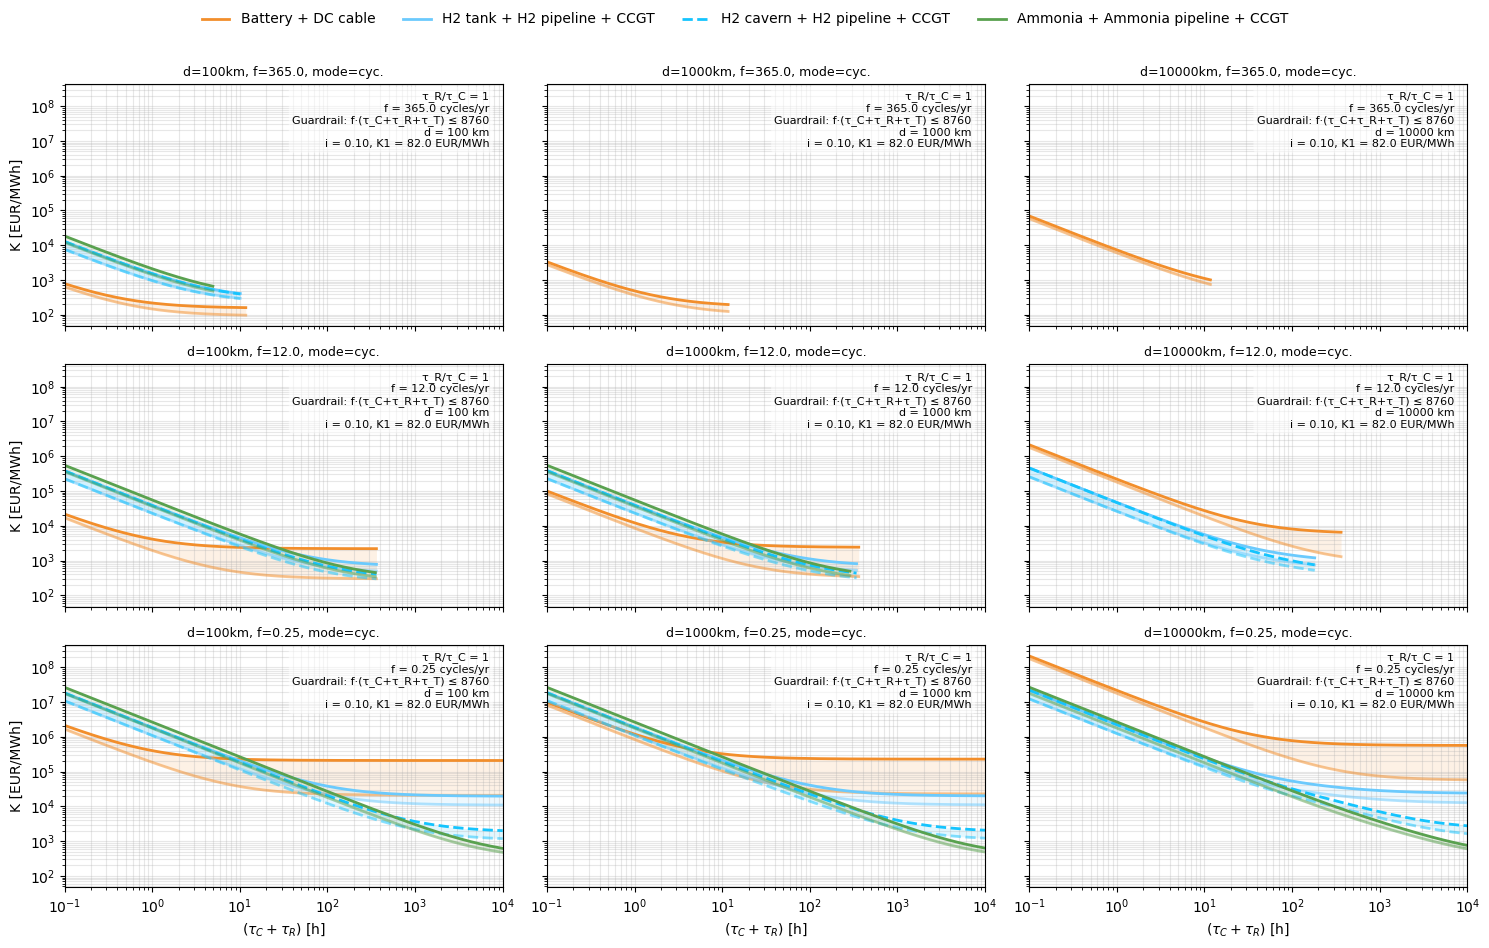

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

HOURS_PER_YEAR = 8760.0
SECONDS_PER_HOUR = globals().get("SECONDS_PER_HOUR", 3600.0)

# Cyclic configuration (no continuous case for combined plots)
cyclic_f_values = [365.0, 12.0, 0.25]  # cycles per year per row

# Combined K(τ_R; d, f) per the paper equation
# K = K1/(ηC ηR r_s(t) r_t(d)) + [Σ C/τC + Σ R/τR + S b + (T d/κ) b_T/τ_R] / [f · ηR · r_s(t) · r_t(d)]


def _line_transit_time_hours(line_dict: dict, distance_km: float) -> float:
    v_mps = max(1e-9, float(line_dict.get("v_mps", 1.0)))
    return (distance_km * 1000.0) / (v_mps * SECONDS_PER_HOUR)


def compute_K_combined(
    tau_R_h: np.ndarray,
    tau_C_h: np.ndarray,
    conv: dict,
    stor: dict,
    trans_lines: dict,
    storage_path: dict,
    line_key: str,
    d_km: float,
    f_cycles_per_year,
    iota_interest: float = None,
    K1: float = None,
    tau_R_line_h: float | np.ndarray | None = None,
):
    """Compute K for a storage+transport chain over a τ_R grid."""
    if iota_interest is None:
        iota_interest = iota
    if K1 is None:
        K1 = K1_EUR_per_kWh

    tau_R_h = np.asarray(tau_R_h, dtype=float)
    tau_C_h = np.asarray(tau_C_h, dtype=float)

    f_array = np.asarray(f_cycles_per_year, dtype=float)
    if f_array.ndim == 0:
        f_array = np.full_like(tau_R_h, float(f_array))
    elif f_array.shape != tau_R_h.shape:
        raise ValueError("f_cycles_per_year must broadcast to tau_R_h")
    f_array = np.maximum(f_array, 1e-9)

    if tau_R_line_h is None:
        tau_R_line_arr = tau_R_h
    else:
        tau_R_line_arr = np.asarray(tau_R_line_h, dtype=float)
        if tau_R_line_arr.ndim == 0:
            tau_R_line_arr = np.full_like(tau_R_h, float(tau_R_line_arr))
        elif tau_R_line_arr.shape != tau_R_h.shape:
            raise ValueError("tau_R_line_h must broadcast to tau_R_h")
        tau_R_line_arr = np.maximum(tau_R_line_arr, 1e-9)

    eta_C = 1.0
    eta_R_eff = 1.0
    for comp in storage_path["conv_in"]:
        eta_C *= conv[comp]["eta"]
    for comp in storage_path["conv_out"]:
        eta_R_eff *= conv[comp]["eta"]

    sum_power_C = sum(conv[c]["C"] * crf(iota_interest, conv[c]["y"]) for c in storage_path["conv_in"])
    sum_power_R = sum(conv[c]["C"] * crf(iota_interest, conv[c]["y"]) for c in storage_path["conv_out"])

    sum_storage = 0.0
    retention_per_h_storage = 1.0
    for comp in storage_path["storage"]:
        S = stor[comp]["S"]; y_comp = stor[comp]["y"]
        sum_storage += S * crf(iota_interest, y_comp)
        retention_per_h_storage *= stor[comp]["retention_per_h"]

    line = trans_lines[line_key]
    b_T = crf(iota_interest, line["y_T"])
    r_t_d = np.power(line["retention_per_km"], float(d_km))
    line_capex_annual_per_kw = (line["T"] * float(d_km) / line["kappa"]) * b_T

    t_eff = HOURS_PER_YEAR / (2.0 * f_array)
    r_s_t = retention_per_h_storage ** t_eff
    r_td = r_s_t * r_t_d

    K_energy = K1 / (eta_C * eta_R_eff * r_td)

    power_term = (sum_power_C / tau_C_h) + (sum_power_R / tau_R_h)
    storage_term = sum_storage
    line_term = line_capex_annual_per_kw / tau_R_line_arr

    K_capital = (power_term + storage_term + line_term) / (f_array * eta_R_eff * r_td)
    return K_energy + K_capital


def build_combined_df_for_year(
    conv_dict: dict,
    stor_dict: dict,
    lines_dict: dict,
    storage_path: dict,
    line_key: str,
    tau_R_grid: np.ndarray,
    tau_ratio_R_over_C_val: float,
    d_km: float,
    f_value: float,
):
    tau_R_local = np.asarray(tau_R_grid, dtype=float)
    tau_C_grid = tau_R_local / tau_ratio_R_over_C_val
    line = lines_dict[line_key]
    t_transit_h = _line_transit_time_hours(line, d_km)

    f_val = max(1e-6, float(f_value))
    tau_R_total = tau_R_local + t_transit_h
    total_dwell = tau_C_grid + tau_R_total
    dwell_mask = (f_val * total_dwell) <= HOURS_PER_YEAR
    tau_R_local = tau_R_local[dwell_mask]
    tau_C_grid = tau_C_grid[dwell_mask]
    tau_R_total = tau_R_total[dwell_mask]
    if tau_R_local.size == 0:
        return pd.DataFrame({"tau_R_h": [], "tau_C_h": [], "f_cycles": [], "K_EUR_per_kWh": []})

    f_array = np.full_like(tau_R_local, f_val)

    K_vals = compute_K_combined(
        tau_R_local,
        tau_C_grid,
        conv_dict,
        stor_dict,
        lines_dict,
        storage_path,
        line_key,
        d_km,
        f_array,
        iota_interest=iota,
        K1=K1_EUR_per_kWh,
        tau_R_line_h=tau_R_total,
    )
    return pd.DataFrame({
        "tau_R_h": tau_R_local,
        "tau_C_h": tau_C_grid,
        "f_cycles": f_array,
        "K_EUR_per_kWh": K_vals,
    })

combined_cases = {
    "Battery + DC cable": {
        "storage_key": "Battery",
        "line_key": "DC cable",
        "color": colours["Battery"],
        "linestyle": "-",
    },
    "H2 tank + H2 pipeline + CCGT": {
        "storage_key": "H2 tank",
        "line_key": "Hydrogen pipeline",
        "color": colours["H2 tank"],
        "linestyle": linestyles.get("H2 tank", "-"),
    },
    "H2 cavern + H2 pipeline + CCGT": {
        "storage_key": "H2 cavern",
        "line_key": "Hydrogen pipeline",
        "color": colours["H2 cavern"],
        "linestyle": linestyles.get("H2 cavern", "--"),
    },
    "Ammonia + Ammonia pipeline + CCGT": {
        "storage_key": "Ammonia",
        "line_key": "Ammonia pipeline",
        "color": colours["Ammonia"],
        "linestyle": linestyles.get("Ammonia", "-"),
    },
}

combined_tau_R = np.geomspace(0.1, 1e4, 400)

row_configs = [
    {
        "label": f"f = {f_val}",
        "phi_param": f_val,
        "subtitle": f"f={f_val}",
        "info_text": (
            f"f = {f_val} cycles/yr\n"
            f"Guardrail: f·(τ_C+τ_R+τ_T) ≤ 8760"
        ),
    }
    for f_val in cyclic_f_values
]

col_distances_km = [100.0, 1000.0, 10000.0]

fig_C, axes_C = plt.subplots(len(row_configs), len(col_distances_km), figsize=(15, 9.5), sharex=True, sharey=True)

for r_idx, row_cfg in enumerate(row_configs):
    for c_idx, d_val in enumerate(col_distances_km):
        ax = axes_C[r_idx, c_idx]
        panel_xmax = 0.0
        for case_name, cfg in combined_cases.items():
            storage_path = tech_paths[cfg["storage_key"]]
            line_key = cfg["line_key"]
            color = cfg["color"]
            ls = cfg["linestyle"]

            df30 = build_combined_df_for_year(
                conv_2030, stor_2030, trans_lines_2030,
                storage_path, line_key, combined_tau_R, tau_ratio_R_over_C,
                d_val, row_cfg["phi_param"]
            )
            df50 = build_combined_df_for_year(
                conv_2050, stor_2050, trans_lines_2050,
                storage_path, line_key, combined_tau_R, tau_ratio_R_over_C,
                d_val, row_cfg["phi_param"]
            )

            if df30.empty or df50.empty:
                continue

            df30 = df30.sort_values("tau_R_h")
            df50 = df50.sort_values("tau_R_h")

            x = df30["tau_R_h"].values
            y30 = 1000.0 * df30["K_EUR_per_kWh"].values
            y50 = 1000.0 * df50["K_EUR_per_kWh"].values

            ax.plot(x, y30, label=case_name if (r_idx == 0 and c_idx == 0) else None,
                    color=color, lw=2, linestyle=ls)
            ax.plot(x, y50, color=color, lw=2, linestyle=ls, alpha=0.5)
            ax.fill_between(x, y30, y50, color=color, alpha=0.12, linewidth=0)

            panel_xmax = max(panel_xmax, float(x.max()))

        ax.set_xscale("log"); ax.set_yscale("log")
        ax.grid(True, which="both", alpha=0.3)
        if r_idx == len(row_configs) - 1:
            ax.set_xlabel(r"$(\tau_C+\tau_R)$ [h]")
        if c_idx == 0:
            ax.set_ylabel("K [EUR/MWh]")

        ax.set_title(
            f"d={int(d_val)}km, {row_cfg['subtitle']}, mode=cyc.",
            fontsize=9,
        )
        if panel_xmax > 0:
            ax.set_xlim(0.1, max(2.0, min(1e4, panel_xmax)))
        else:
            ax.set_xlim(0.1, 1e4)

        annotation_text = (
            f"τ_R/τ_C = {tau_ratio_R_over_C:g}\n"
            f"{row_cfg['info_text']}\n"
            f"d = {int(d_val)} km\n"
            f"i = {iota:.2f}, K1 = {K1_EUR_per_MWh:.1f} EUR/MWh"
        )
        ax.text(
            0.97,
            0.97,
            annotation_text,
            transform=ax.transAxes,
            fontsize=8,
            va='top',
            ha='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.55, edgecolor='none'),
        )

handles, labels = axes_C[0,0].get_legend_handles_labels()
if not handles:
    for row in axes_C:
        for ax_ in row:
            handles, labels = ax_.get_legend_handles_labels()
            if handles:
                break
        if handles:
            break

fig_C.legend(handles, labels, loc='upper center', ncol=4, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])

save_fig(fig_C, "combined_storage_transport_2030_2050_multi_phi_d", 
         output_dir="/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images")

In [12]:
def _scenario_dicts(year_label):
    """Return (conversion, storage, transmission) dicts for a given scenario year."""
    if year_label is None:
        raise ValueError("year_label must be provided")
    label = str(year_label).strip()
    scenarios = {
        "2030": (conv_2030, stor_2030, trans_lines_2030),
        "2050": (conv_2050, stor_2050, trans_lines_2050),
    }
    if label not in scenarios:
        raise ValueError(f"Unknown year_label '{year_label}'. Expected one of {sorted(scenarios.keys())}.")
    return scenarios[label]


/var/folders/6b/x50zyszd41z391jpwblh3ryh0000gn/T/ipykernel_32568/3259025864.py:243: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.12, 1, 0.92])


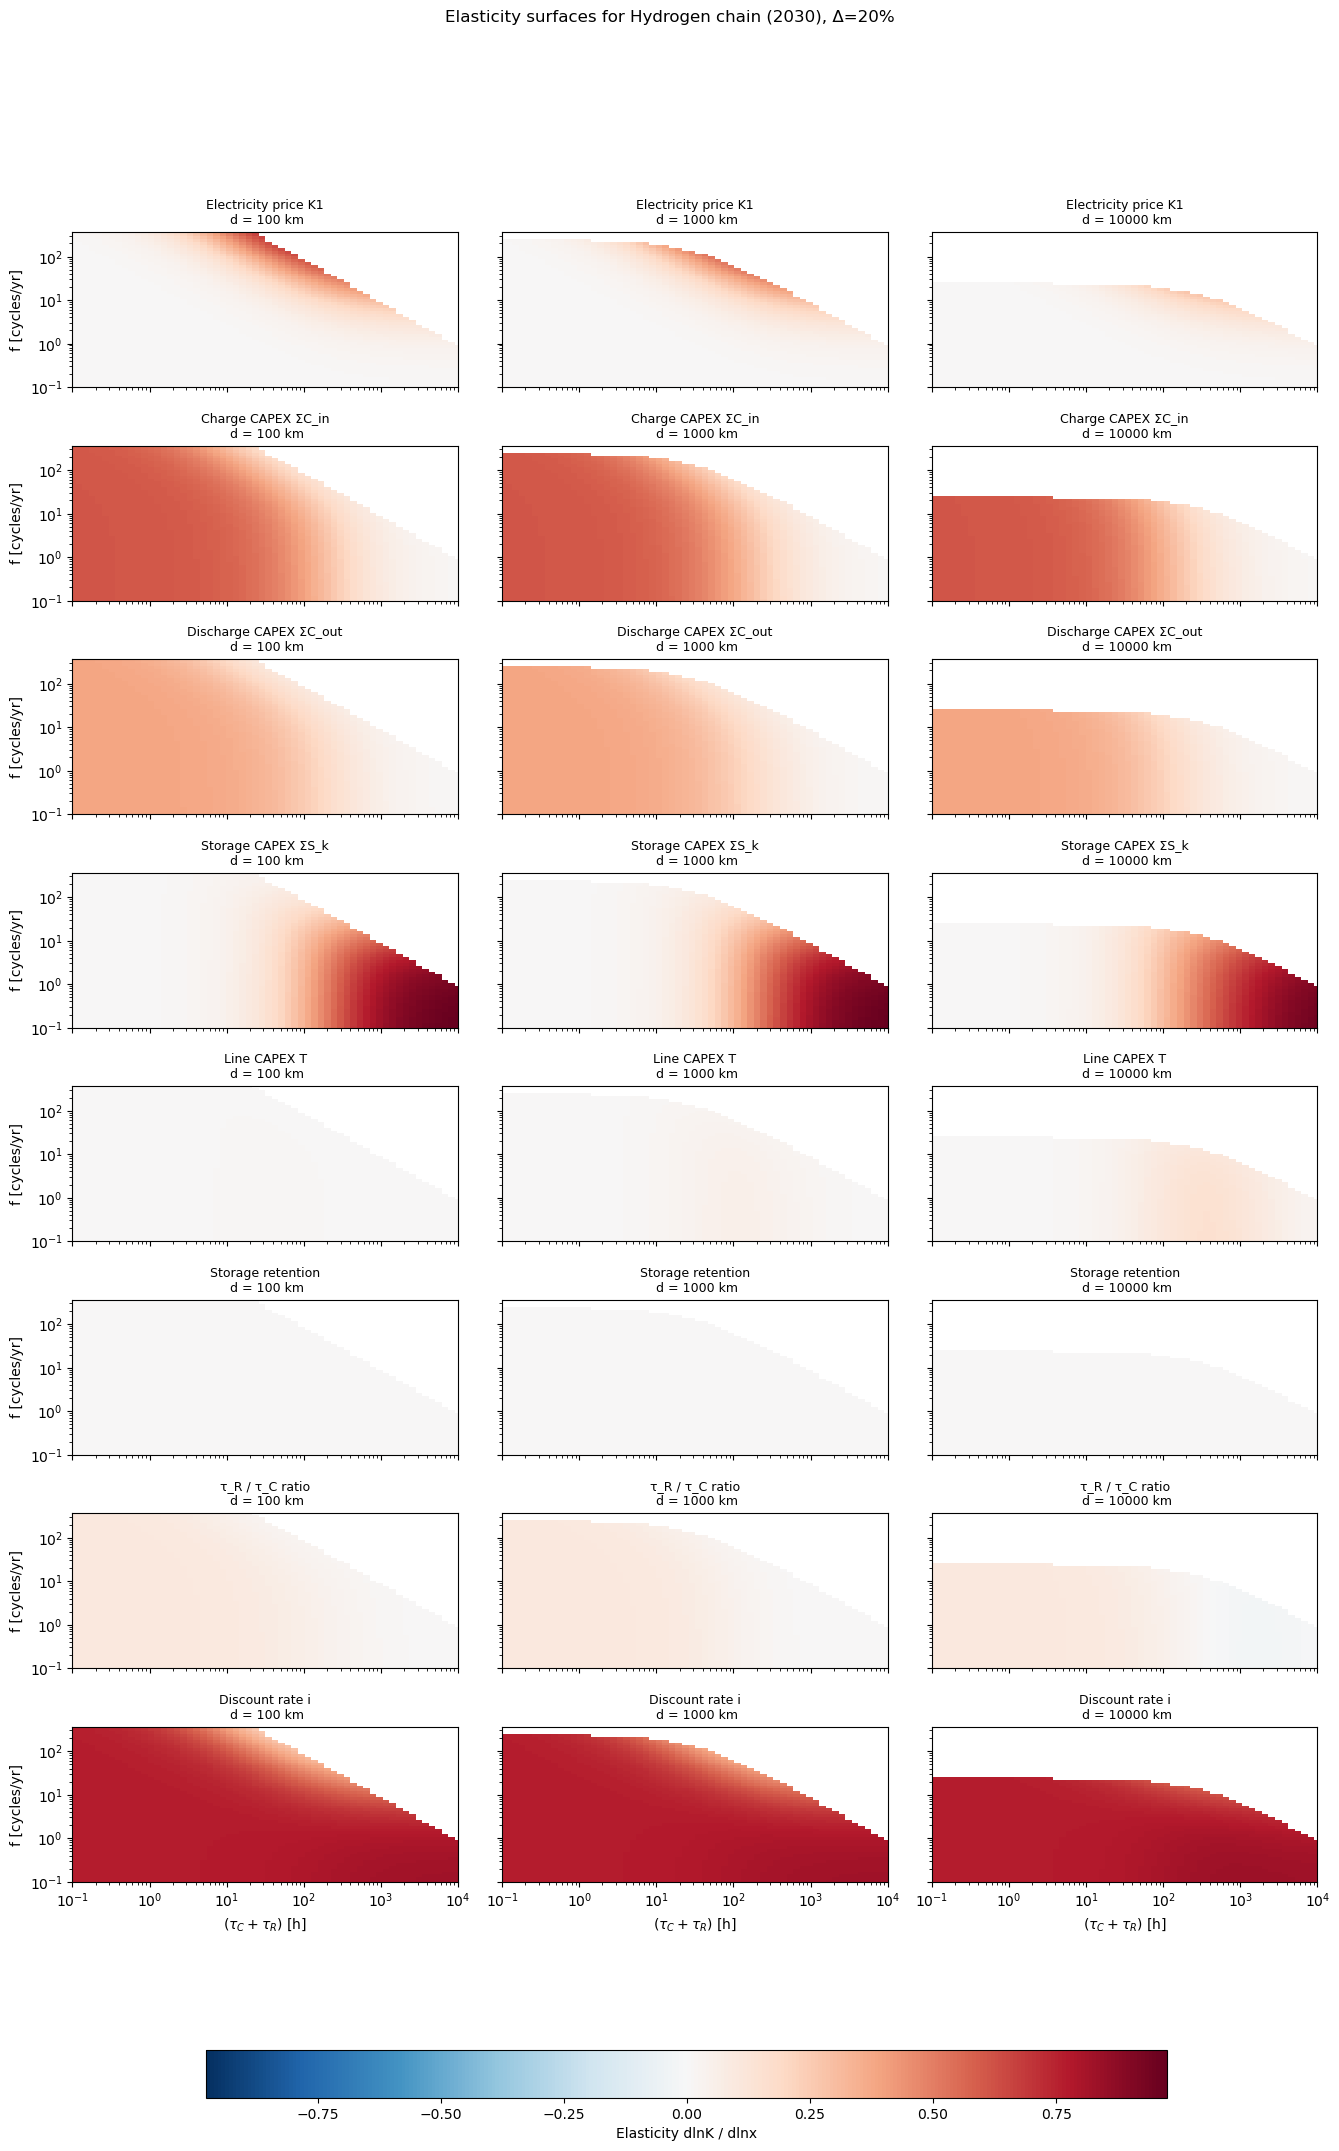

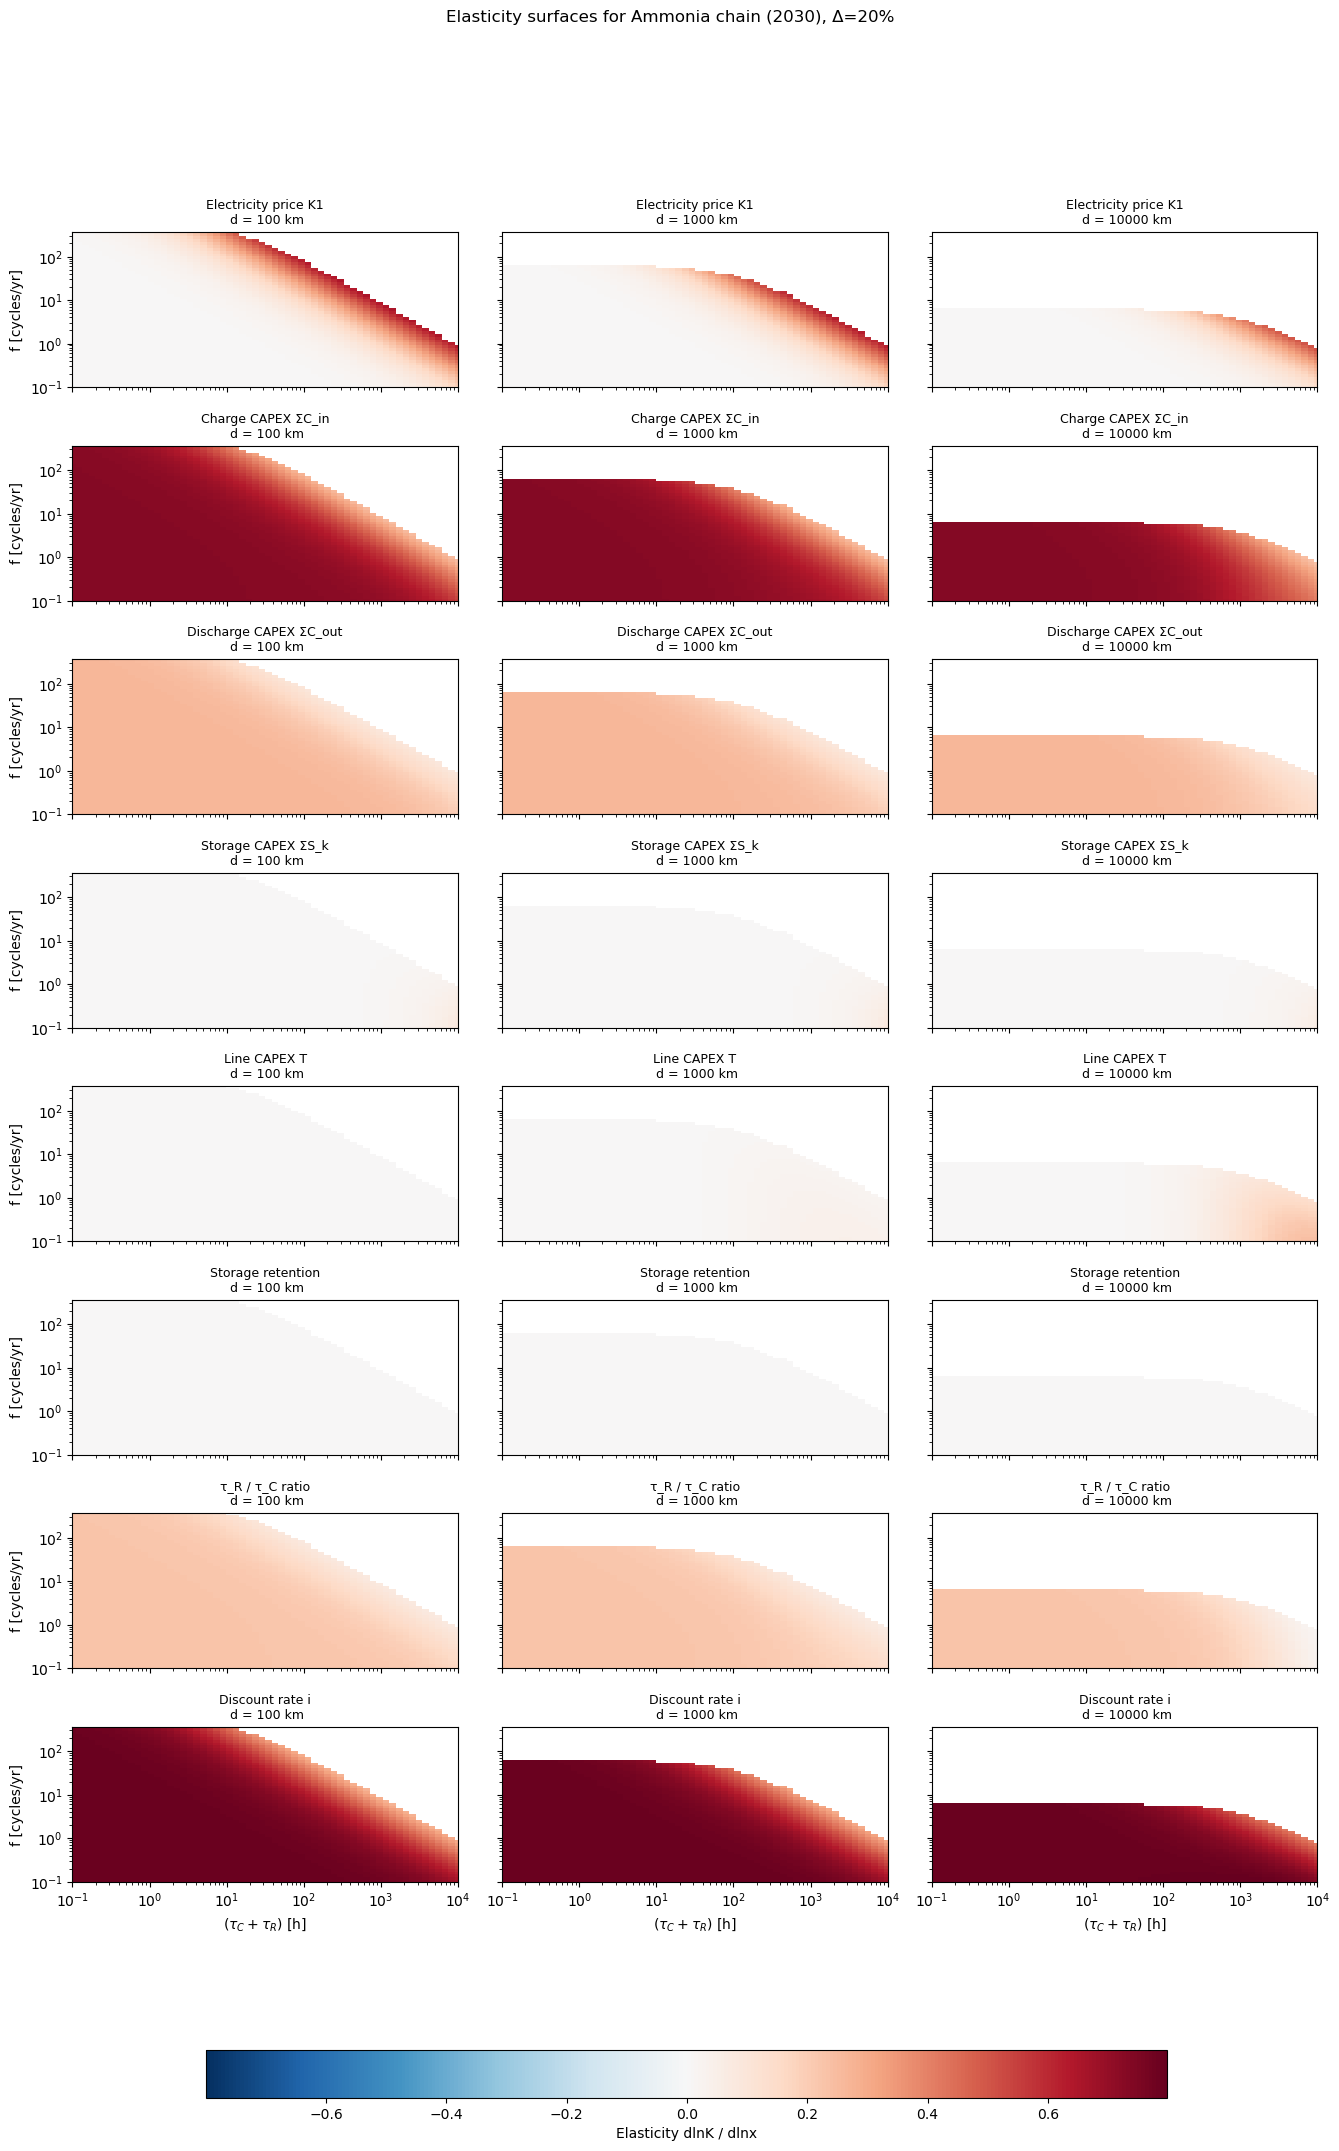

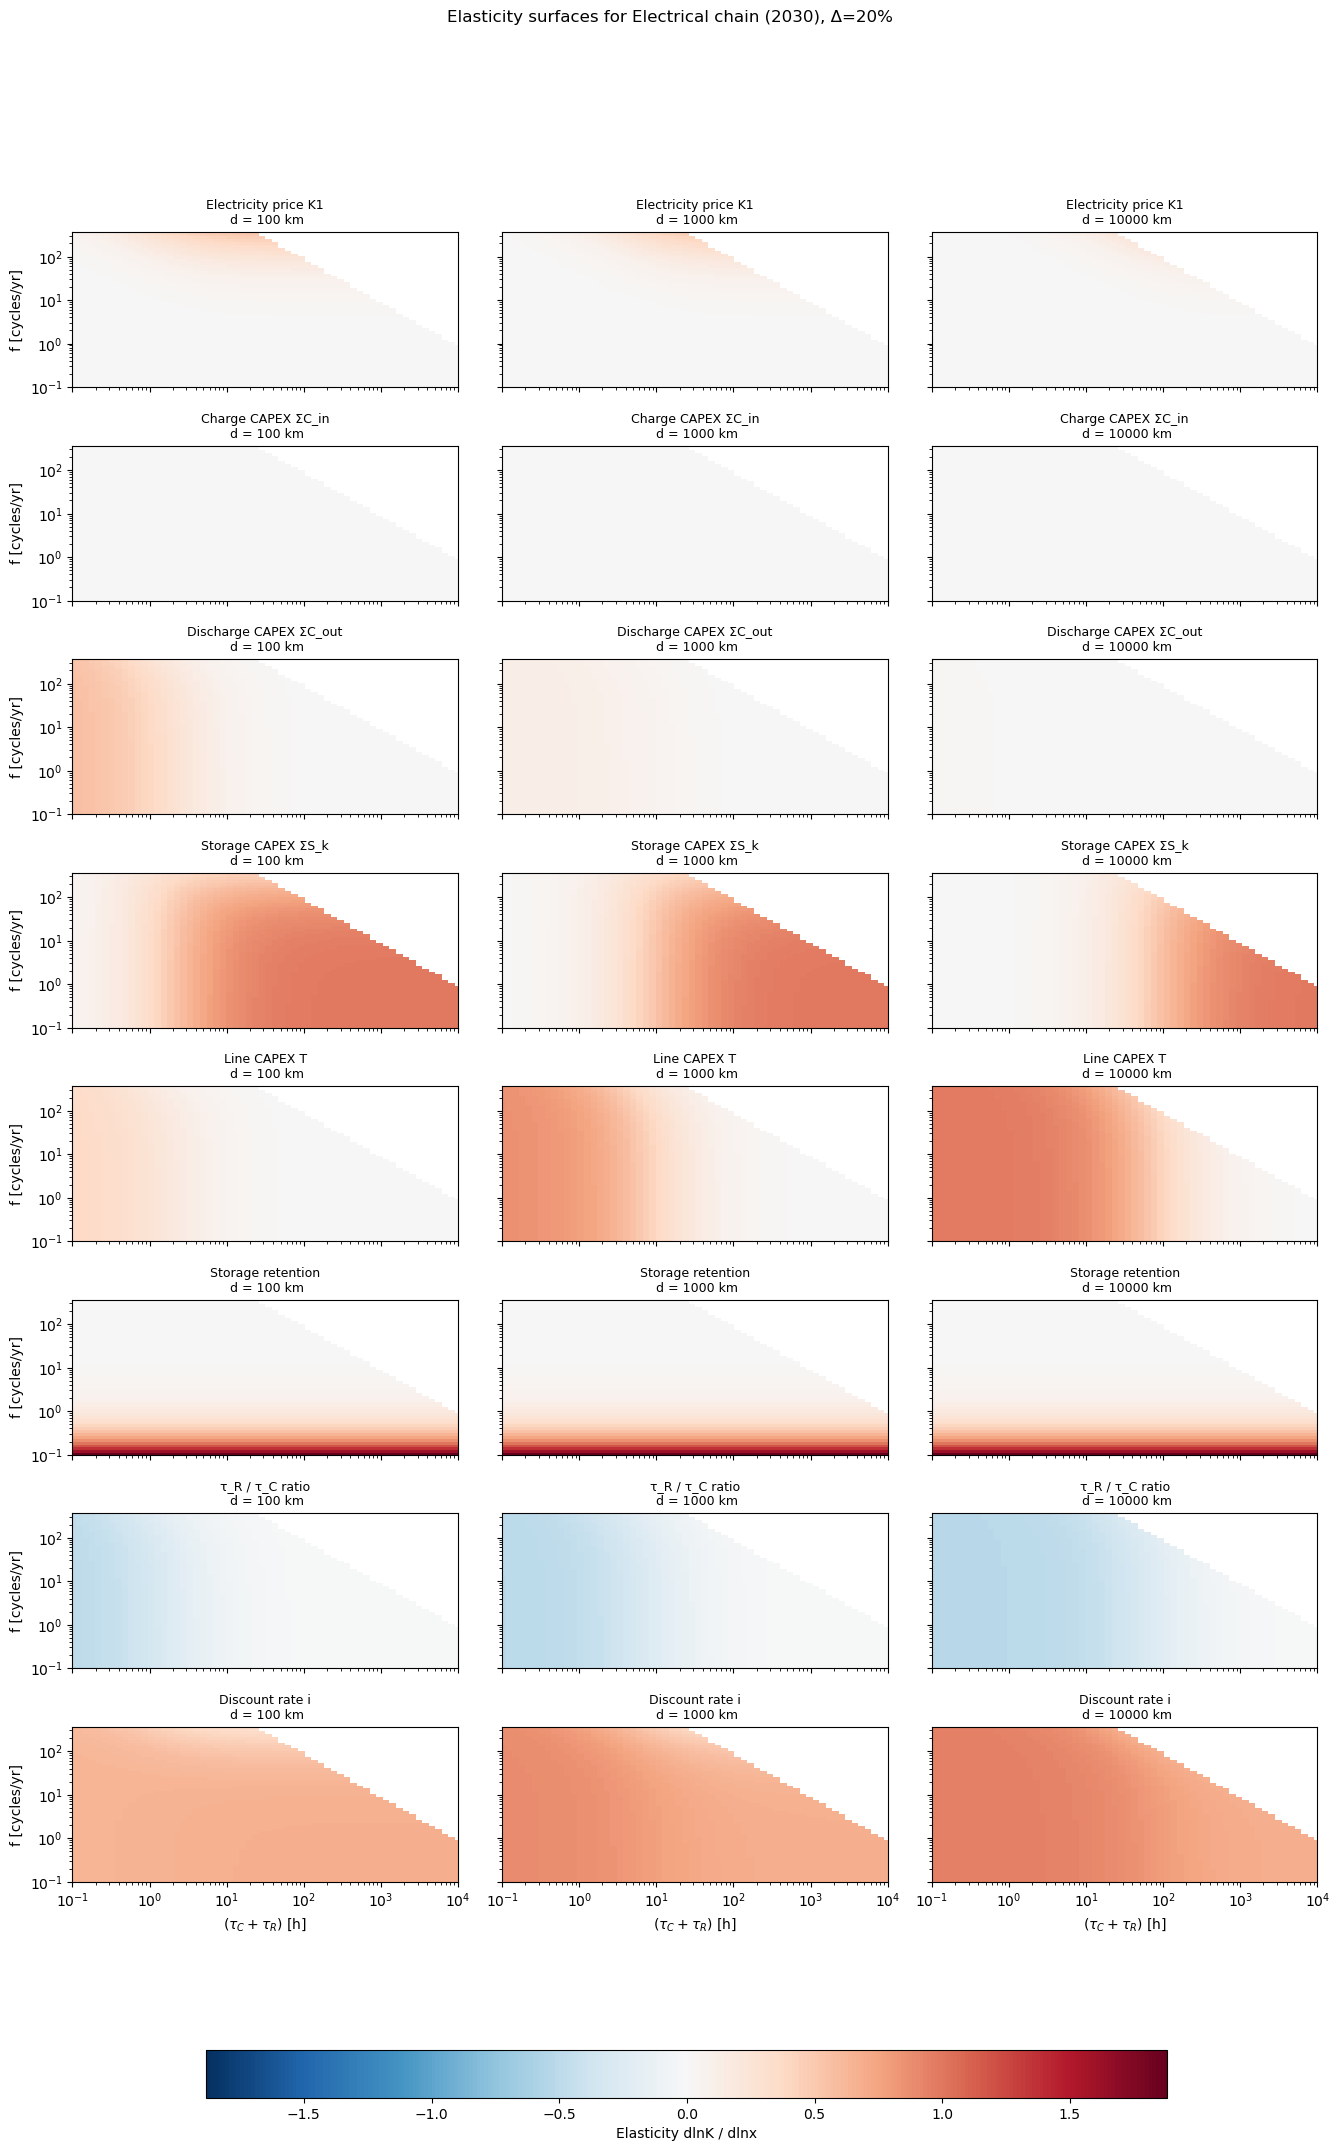

In [13]:
import copy

heatmap_params = [
    ("Electricity price K1", "K1"),
    ("Charge CAPEX ΣC_in", "conv_in"),
    ("Discharge CAPEX ΣC_out", "conv_out"),
    ("Storage CAPEX ΣS_k", "storage_cap"),
    ("Line CAPEX T", "line_cap"),
    ("Storage retention", "storage_ret"),
    ("τ_R / τ_C ratio", "tau_ratio"),
    ("Discount rate i", "discount_rate"),
]
heatmap_distances = (100.0, 1000.0, 10000.0)
heatmap_tau_total_grid = np.geomspace(0.1, 1e4, 60)
heatmap_f_grid = np.geomspace(0.1, 365.0, 55)
heatmap_delta = 0.20
heatmap_case_labels = [
    ("H2 tank + H2 pipeline + CCGT", "Hydrogen chain"),
    ("Ammonia + Ammonia pipeline + CCGT", "Ammonia chain"),
    ("Battery + DC cable", "Electrical chain"),
]


def _scale_retention(retention_per_h, scale_factor):
    leakage = max(0.0, 1.0 - float(retention_per_h))
    leakage = np.clip(leakage * scale_factor, 0.0, 0.999999)
    return max(1e-9, 1.0 - leakage)


def _scaled_dicts_for_target(conv_dict, stor_dict, lines_dict, storage_path, line_key, target, scale_factor):
    conv_mod = copy.deepcopy(conv_dict)
    stor_mod = copy.deepcopy(stor_dict)
    lines_mod = copy.deepcopy(lines_dict)
    K1_val = K1_EUR_per_kWh
    iota_val = iota

    if target == "K1":
        K1_val *= scale_factor
    elif target == "conv_in":
        for comp in storage_path["conv_in"]:
            conv_mod[comp]["C"] *= scale_factor
    elif target == "conv_out":
        for comp in storage_path["conv_out"]:
            conv_mod[comp]["C"] *= scale_factor
    elif target == "storage_cap":
        for comp in storage_path["storage"]:
            stor_mod[comp]["S"] *= scale_factor
    elif target == "line_cap":
        lines_mod[line_key]["T"] *= scale_factor
    elif target == "storage_ret":
        for comp in storage_path["storage"]:
            stor_mod[comp]["retention_per_h"] = _scale_retention(stor_mod[comp]["retention_per_h"], scale_factor)
    elif target == "line_ret":
        lines_mod[line_key]["retention_per_km"] = _scale_retention(lines_mod[line_key]["retention_per_km"], scale_factor)
    elif target == "tau_ratio":
        pass
    elif target == "discount_rate":
        iota_val = max(1e-6, iota * scale_factor)
    else:
        raise ValueError(f"Unsupported target: {target}")

    return conv_mod, stor_mod, lines_mod, K1_val, iota_val


def _combined_surface(conv_dict, stor_dict, lines_dict, storage_path, line_key,
                      d_km, tau_total_grid, f_grid, K1_scalar, tau_ratio_value=None, iota_value=None):
    ratio = tau_ratio_R_over_C if tau_ratio_value is None else float(tau_ratio_value)
    ratio = max(1e-6, ratio)
    tau_total = tau_total_grid[None, :]
    tau_C = tau_total / (1.0 + ratio)
    tau_R = tau_total - tau_C

    f_vals = f_grid[:, None]
    line = lines_dict[line_key]
    tau_T = _line_transit_time_hours(line, d_km)
    tau_R_line = tau_R + tau_T
    total_dwell = tau_C + tau_R_line

    tau_C_matrix = np.broadcast_to(tau_C, (f_vals.shape[0], tau_total.shape[1]))
    tau_R_matrix = np.broadcast_to(tau_R, (f_vals.shape[0], tau_total.shape[1]))
    tau_R_line_matrix = np.broadcast_to(tau_R_line, (f_vals.shape[0], tau_total.shape[1]))
    total_dwell_matrix = np.broadcast_to(total_dwell, (f_vals.shape[0], tau_total.shape[1]))
    f_matrix = np.broadcast_to(f_vals, (f_vals.shape[0], tau_total.shape[1]))

    feasible = (f_matrix * total_dwell_matrix) <= HOURS_PER_YEAR
    if not np.any(feasible):
        surface = np.full_like(total_dwell_matrix, np.nan, dtype=float)
        return surface, feasible

    tau_R_flat = tau_R_matrix[feasible]
    tau_C_flat = tau_C_matrix[feasible]
    f_flat = f_matrix[feasible]
    tau_R_line_flat = tau_R_line_matrix[feasible]

    iota_eff = iota if iota_value is None else max(1e-6, float(iota_value))

    K_vals = compute_K_combined(
        tau_R_flat,
        tau_C_flat,
        conv_dict,
        stor_dict,
        lines_dict,
        storage_path,
        line_key,
        d_km,
        f_flat,
        iota_interest=iota_eff,
        K1=K1_scalar,
        tau_R_line_h=tau_R_line_flat,
    )

    surface = np.full_like(total_dwell_matrix, np.nan, dtype=float)
    surface[feasible] = K_vals
    return surface, feasible


def compute_elasticity_surface(case_name, year_label, distance_km, target_key,
                               tau_total_grid, f_grid, delta_frac=0.2):
    conv_base, stor_base, lines_base = _scenario_dicts(year_label)
    cfg = combined_cases[case_name]
    storage_path = tech_paths[cfg["storage_key"]]
    line_key = cfg["line_key"]
    base_ratio = tau_ratio_R_over_C

    surfaces = {}
    masks = {}
    for scale in (1.0, 1.0 + delta_frac, 1.0 - delta_frac):
        ratio_val = base_ratio
        iota_val = iota
        if target_key == "tau_ratio":
            conv_mod = copy.deepcopy(conv_base)
            stor_mod = copy.deepcopy(stor_base)
            lines_mod = copy.deepcopy(lines_base)
            K1_val = K1_EUR_per_kWh
            ratio_val = max(1e-6, base_ratio * scale)
        else:
            conv_mod, stor_mod, lines_mod, K1_val, iota_val = _scaled_dicts_for_target(
                conv_base, stor_base, lines_base, storage_path, line_key, target_key, scale
            )

        surf, mask = _combined_surface(
            conv_mod,
            stor_mod,
            lines_mod,
            storage_path,
            line_key,
            distance_km,
            tau_total_grid,
            f_grid,
            K1_val,
            tau_ratio_value=ratio_val,
            iota_value=iota_val,
        )
        surfaces[scale] = surf
        masks[scale] = mask

    base = surfaces[1.0]
    plus = surfaces[1.0 + delta_frac]
    minus = surfaces[1.0 - delta_frac]

    elasticity = np.full_like(base, np.nan)
    valid_mask = masks[1.0]
    for other_mask in masks.values():
        valid_mask &= other_mask

    denom = 2.0 * delta_frac * base
    elasticity[valid_mask] = (plus[valid_mask] - minus[valid_mask]) / denom[valid_mask]
    return elasticity


def plot_elasticity_heatmaps(case_name,
                             year_label="2030",
                             distances=heatmap_distances,
                             tau_total_grid=heatmap_tau_total_grid,
                             f_grid=heatmap_f_grid,
                             param_list=heatmap_params,
                             delta_frac=heatmap_delta,
                             case_label=None):
    cfg = combined_cases.get(case_name)
    if cfg is None:
        raise ValueError(f"Unknown case: {case_name}")

    results = {}
    for title, key in param_list:
        for d in distances:
            surf = compute_elasticity_surface(
                case_name,
                year_label,
                d,
                key,
                tau_total_grid,
                f_grid,
                delta_frac=delta_frac,
            )
            results[(title, d)] = surf

    vmax = np.nanmax([np.nanmax(np.abs(arr)) for arr in results.values() if np.any(np.isfinite(arr))])
    if not np.isfinite(vmax) or vmax == 0:
        vmax = 1.0

    fig, axes = plt.subplots(len(param_list), len(distances), figsize=(4.5 * len(distances), 3.0 * len(param_list)), sharex=True, sharey=True)
    if len(param_list) == 1:
        axes = np.array([axes])
    if len(distances) == 1:
        axes = axes[:, np.newaxis]

    mesh_tau, mesh_f = np.meshgrid(tau_total_grid, f_grid)
    cmap = plt.cm.RdBu_r
    pcm = None

    for r_idx, (title, key) in enumerate(param_list):
        for c_idx, d in enumerate(distances):
            ax = axes[r_idx, c_idx]
            surf = results[(title, d)]
            pcm = ax.pcolormesh(mesh_tau, mesh_f, surf, shading='nearest', cmap=cmap, vmin=-vmax, vmax=vmax)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim(tau_total_grid.min(), tau_total_grid.max())
            ax.set_ylim(f_grid.min(), f_grid.max())
            if r_idx == len(param_list) - 1:
                ax.set_xlabel(r"$(\tau_C+\tau_R)$ [h]")
            if c_idx == 0:
                ax.set_ylabel("f [cycles/yr]")
            ax.set_title(f"{title}\n d = {int(d)} km", fontsize=9)
            ax.grid(False)

    label = case_label or case_name
    fig.suptitle(
        f"Elasticity surfaces for {label} ({year_label}), Δ={int(delta_frac*100)}%",
        fontsize=12,
    )

    if pcm is not None:
        cbar = fig.colorbar(
            pcm,
            ax=axes.ravel().tolist(),
            orientation='horizontal',
            fraction=0.026,
            pad=0.12,
        )
        cbar.set_label("Elasticity dlnK / dlnx")

    fig.tight_layout(rect=[0, 0.12, 1, 0.92])
    fig.subplots_adjust(bottom=0.2)
    return fig


heatmap_figures = {}
for case_name, label in heatmap_case_labels:
    heatmap_figures[case_name] = plot_elasticity_heatmaps(case_name=case_name, case_label=label)

plt.show()

### Sobol' global sensitivity
The elasticity maps show local slopes, but to rank drivers when each spans a different uncertainty range we run a Sobol' variance-decomposition. We treat every uncertain input as a multiplier around its nominal value (with wider bounds for distance and cycling frequency), draw Saltelli samples, evaluate \(K\) at a representative point \((\tau_C+\tau_R)=240\,\text{h}, f=12\,\text{yr}^{-1}, d=1000\,\text{km})\) for each chain/year, and report the first-order (main effect) and total-order indices. Large gaps between total and first-order indices flag strong interactions.

/var/folders/6b/x50zyszd41z391jpwblh3ryh0000gn/T/ipykernel_32568/335644137.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  sobol_param_values = saltelli.sample(sobol_problem, sobol_sample_size, calc_second_order=False)


,year,case,parameter,key,S1,ST
19,2030,Ammonia chain,Cycle frequency f,frequency,0.825537,0.881055
17,2030,Ammonia chain,Discount rate i,discount_rate,0.032180,0.099751
16,2030,Ammonia chain,τ_R / τ_C ratio,tau_ratio,0.020436,0.036436
11,2030,Ammonia chain,Charge CAPEX ΣC_in,conv_in,0.000718,0.016223
12,2030,Ammonia chain,Discharge CAPEX ΣC_out,conv_out,-0.000843,0.001344
29,2030,Electrical chain,Cycle frequency f,frequency,0.830435,0.905618
27,2030,Electrical chain,Discount rate i,discount_rate,0.026254,0.069435
28,2030,Electrical chain,Delivery distance d,distance,0.023358,0.046492
23,2030,Electrical chain,Storage CAPEX ΣS_k,storage_cap,0.016311,0.024666
26,2030,Electrical chain,τ_R / τ_C ratio,tau_ratio,-0.000293,0.000509


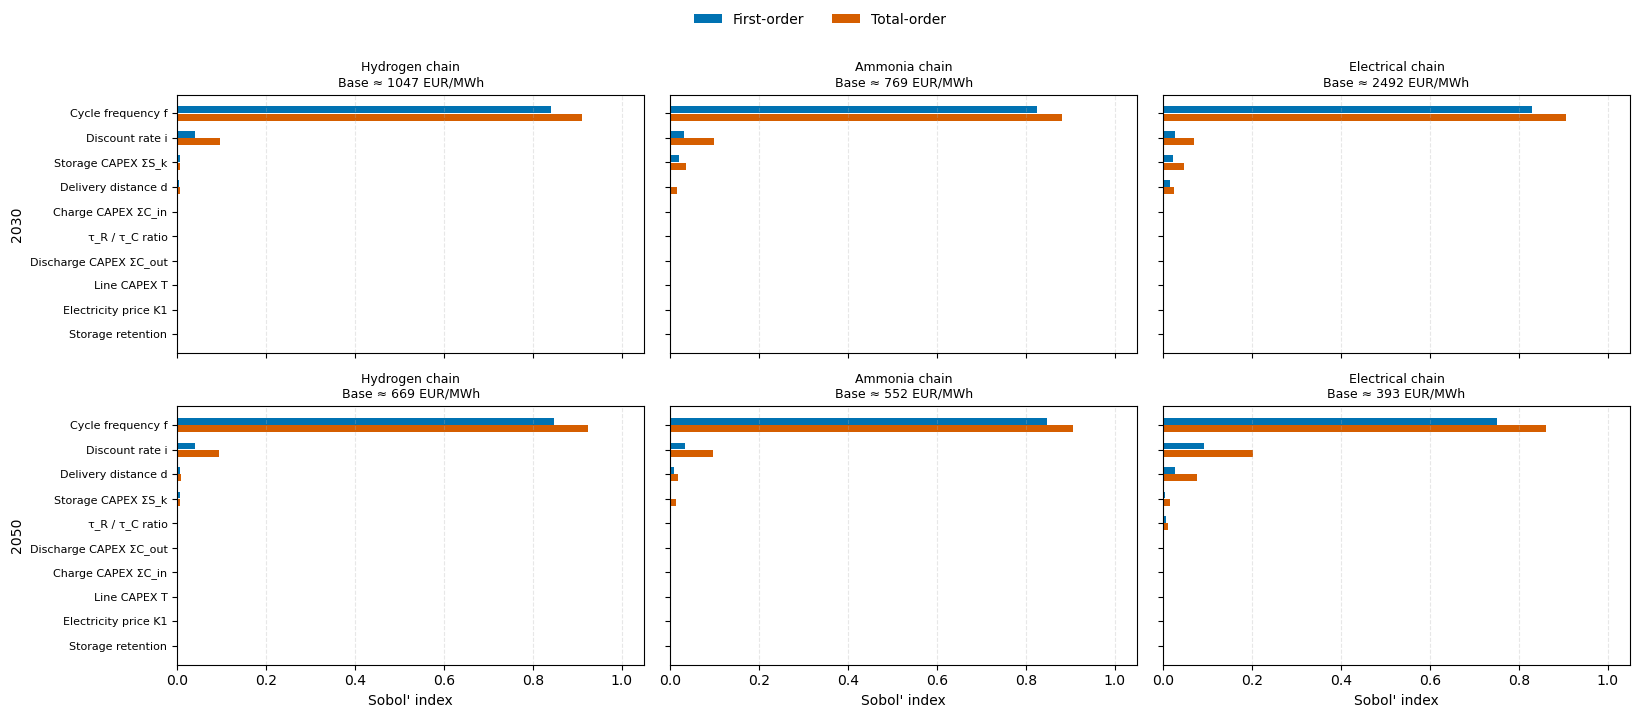

In [14]:
from SALib.sample import saltelli
from SALib.analyze import sobol

sobol_years = ["2030", "2050"]
sobol_case_labels = heatmap_case_labels
sobol_base_state = {"tau_total_h": 240.0, "f_cycles": 12.0, "distance_km": 1000.0}
sobol_default_delta = float(heatmap_delta)
sobol_bounds_map = {
    "tau_ratio": (0.4, 2.5),
    "distance": (0.25, 4.0),
    "frequency": (0.25, 4.0),
    "discount_rate": (0.5, 1.5),
}
sobol_param_specs = heatmap_params + [("Delivery distance d", "distance"), ("Cycle frequency f", "frequency")]
sobol_param_names = [key for _, key in sobol_param_specs]
sobol_param_labels = [title for title, _ in sobol_param_specs]
sobol_bounds = [
    list(sobol_bounds_map.get(key, (1.0 - sobol_default_delta, 1.0 + sobol_default_delta)))
    for key in sobol_param_names
]

sobol_problem = {"num_vars": len(sobol_param_names), "names": sobol_param_names, "bounds": sobol_bounds}
sobol_sample_size = 256
sobol_param_values = saltelli.sample(sobol_problem, sobol_sample_size, calc_second_order=False)
sobol_scale_maps = [
    {name: float(val) for name, val in zip(sobol_param_names, row)}
    for row in sobol_param_values
]


def _sobol_chain_cost(case_name, year_label, scale_map):
    conv_base, stor_base, lines_base = _scenario_dicts(year_label)
    cfg = combined_cases[case_name]
    storage_path = tech_paths[cfg["storage_key"]]
    line_key = cfg["line_key"]

    conv_mod = copy.deepcopy(conv_base)
    stor_mod = copy.deepcopy(stor_base)
    lines_mod = copy.deepcopy(lines_base)
    K1_val = K1_EUR_per_kWh
    iota_val = iota
    ratio_val = tau_ratio_R_over_C
    distance_val = sobol_base_state["distance_km"]
    f_val = sobol_base_state["f_cycles"]

    for key, scale in scale_map.items():
        scale = float(scale)
        if key == "tau_ratio":
            ratio_val = max(1e-6, ratio_val * scale)
        elif key == "distance":
            distance_val = max(1e-6, distance_val * scale)
        elif key == "frequency":
            f_val = max(1e-6, f_val * scale)
        else:
            conv_mod, stor_mod, lines_mod, K1_val, iota_val = _scaled_dicts_for_target(
                conv_mod,
                stor_mod,
                lines_mod,
                storage_path,
                line_key,
                key,
                scale,
            )

    tau_total = max(1e-6, sobol_base_state["tau_total_h"])
    tau_C = tau_total / (1.0 + ratio_val)
    tau_R = tau_total - tau_C
    tau_transit = _line_transit_time_hours(lines_mod[line_key], distance_val)
    tau_R_line = tau_R + tau_transit

    K_val = compute_K_combined(
        np.array([tau_R]),
        np.array([tau_C]),
        conv_mod,
        stor_mod,
        lines_mod,
        storage_path,
        line_key,
        distance_val,
        np.array([f_val]),
        iota_interest=iota_val,
        K1=K1_val,
        tau_R_line_h=np.array([tau_R_line]),
    )[0]
    return float(K_val) * 1000.0  # EUR/MWh


sobol_outputs = {}
ones_map = {name: 1.0 for name in sobol_param_names}
for year_label in sobol_years:
    for case_name, case_label in sobol_case_labels:
        y_vals = np.array([
            _sobol_chain_cost(case_name, year_label, scale_map)
            for scale_map in sobol_scale_maps
        ])
        indices = sobol.analyze(
            sobol_problem,
            y_vals,
            calc_second_order=False,
            print_to_console=False,
        )
        df_indices = pd.DataFrame({
            "parameter": sobol_param_labels,
            "key": sobol_param_names,
            "S1": indices["S1"],
            "ST": indices["ST"],
        })
        df_indices.insert(0, "year", year_label)
        df_indices.insert(1, "case", case_label)
        sobol_outputs[(year_label, case_name)] = {
            "indices": indices,
            "df": df_indices,
            "base_cost": _sobol_chain_cost(case_name, year_label, ones_map),
        }

sobol_summary = pd.concat([payload["df"] for payload in sobol_outputs.values()], ignore_index=True)
display(sobol_summary.sort_values(["year", "case", "ST"], ascending=[True, True, False]).groupby(["year", "case"]).head(5))

fig, axes = plt.subplots(len(sobol_years), len(sobol_case_labels), figsize=(5.5 * len(sobol_case_labels), 3.6 * len(sobol_years)), sharex=True)
axes = np.atleast_2d(axes)
for r_idx, year_label in enumerate(sobol_years):
    for c_idx, (case_name, case_label) in enumerate(sobol_case_labels):
        ax = axes[r_idx, c_idx]
        df_plot = sobol_outputs[(year_label, case_name)]["df"].sort_values("ST", ascending=False)
        y_pos = np.arange(len(df_plot))
        ax.barh(y_pos - 0.15, np.clip(df_plot["S1"], 0, 1), height=0.28, color="#0072b2", label="First-order" if (r_idx == 0 and c_idx == 0) else None)
        ax.barh(y_pos + 0.15, np.clip(df_plot["ST"], 0, 1.2), height=0.28, color="#d55e00", label="Total-order" if (r_idx == 0 and c_idx == 0) else None)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(df_plot["parameter"], fontsize=8)
        ax.invert_yaxis()
        ax.set_xlim(0.0, 1.05)
        if r_idx == len(sobol_years) - 1:
            ax.set_xlabel("Sobol' index")
        if c_idx == 0:
            ax.set_ylabel(year_label)
        else:
            ax.set_yticklabels([])
        base_cost = sobol_outputs[(year_label, case_name)]["base_cost"]
        ax.set_title(f"{case_label}\nBase ≈ {base_cost:.0f} EUR/MWh", fontsize=9)
        ax.grid(True, axis='x', linestyle='--', alpha=0.3)

handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)
fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

### Minimum storage buffer for the no-overflow condition
For a fixed discharge rating \(p_R\) the store must hold at least one full discharge window of energy once retention and reconversion losses are accounted for:
\[
e_{\min} = \frac{p_R\,\tau_R}{\eta_R\,r_s(t)}.
\]
Because \(\tau_R\) is tied to \(\tau_C\) through the ratio \(\tau_R/\tau_C\), different points on the existing LCOE surfaces imply different energy inventory requirements. The chart below treats the requirement on a per-kW-delivered basis—expressed in \si{kWh/kW_{out}} (i.e. hours of storage per unit of discharge capacity)—so it can be scaled to any plant rating simply by multiplication.

Saved: /Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images/lcoe_storage_math_minimum_storage_requirement_vs_cycle.png


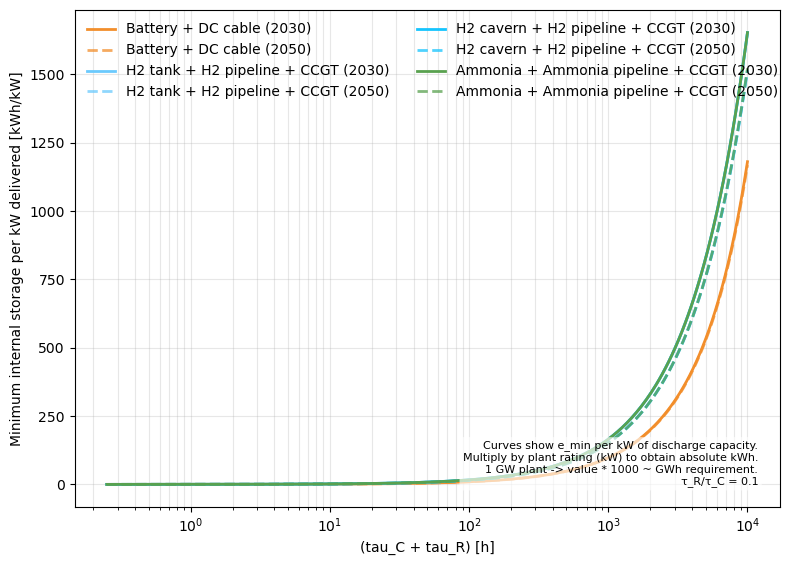

In [ ]:
ecap_tau_total_grid = np.geomspace(0.25, 1e4, 400)
scenario_sets = {"2030": (conv_2030, stor_2030), "2050": (conv_2050, stor_2050)}
line_styles_by_year = {"2030": "-", "2050": "--"}
alpha_by_year = {"2030": 1.0, "2050": 0.75}


def _minimum_storage_hours_per_kw(storage_path: dict, conv_dict: dict, stor_dict: dict, tau_total_grid, tau_ratio):
    tau_total = np.asarray(tau_total_grid, dtype=float)
    tau_ratio = max(1e-6, float(tau_ratio))
    tau_C = tau_total / (1.0 + tau_ratio)
    tau_R = tau_total - tau_C

    eta_R = 1.0
    for comp in storage_path["conv_out"]:
        eta_R *= conv_dict[comp]["eta"]
    retention_per_h = 1.0
    for comp in storage_path["storage"]:
        retention_per_h *= stor_dict[comp]["retention_per_h"]

    avg_dwell = 0.5 * tau_total  # mean time energy resides in storage per cycle
    r_s = np.power(retention_per_h, avg_dwell)
    r_s = np.maximum(r_s, 1e-12)  # numerically guard against underflow

    min_hours_per_kw = tau_R / (eta_R * r_s)
    return tau_total, min_hours_per_kw


fig_ecap, ax_ecap = plt.subplots(figsize=(8.5, 5.75))
for case_name, cfg in combined_cases.items():
    storage_path = tech_paths[cfg["storage_key"]]
    color = cfg["color"]
    for year_label, (conv_dict, stor_dict) in scenario_sets.items():
        tau_vals, hours_per_kw = _minimum_storage_hours_per_kw(
            storage_path,
            conv_dict,
            stor_dict,
            ecap_tau_total_grid,
            tau_ratio_R_over_C,
        )
        ax_ecap.plot(
            tau_vals,
            hours_per_kw,
            color=color,
            linestyle=line_styles_by_year[year_label],
            alpha=alpha_by_year[year_label],
            lw=2,
            label=f"{case_name} ({year_label})"
        )

ax_ecap.set_xscale("log")
ax_ecap.set_xlabel("(tau_C + tau_R) [h]")
ax_ecap.set_ylabel("Minimum internal storage per kW delivered [kWh/kW]")
ax_ecap.grid(True, which="both", alpha=0.3)

annotation = (
    "Curves show e_min per kW of discharge capacity.\n"
    "Multiply by plant rating (kW) to obtain absolute kWh.\n"
    "1 GW plant -> value * 1000 ~ GWh requirement."
)
ax_ecap.text(
    0.97,
    0.04,
    annotation + f"\nτ_R/τ_C = {tau_ratio_R_over_C:g}",
    transform=ax_ecap.transAxes,
    fontsize=8,
    va="bottom",
    ha="right",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.65, edgecolor="none"),
)

handles, labels = ax_ecap.get_legend_handles_labels()
ax_ecap.legend(handles, labels, loc="upper left", ncol=2, frameon=False)

fig_ecap.tight_layout()
save_fig(
    fig_ecap,
    "minimum_storage_requirement_vs_cycle",
    output_dir="/Users/carlopalazzi/Documents/Oxford 2023-25/20250331 Co-optimizing paper/green-condor-report/images",
)

plt.show()